# FIT5196 Assignment 3: Data Cleansing
<b>Group Number:</b> 149 <br>
<b>Student Names:</b> Sachit Anil Kumar, Xinming Huang <br>
<b>Student IDs:</b> 29392624, 26989166

<b>Tutor:</b> Mohammad <br>
<b>Tutorial:</b> Tuesday 12:00 PM to 2:00 PM, B4.77

<b>Date:</b> 01/09/2019 <br>
<b>Version:</b> 1.0 <br>
<b>Environment:</b> Python 3.6, Anaconda Navigator 1.8.7 and jupyter notebook 5.5.0

<b>Libraries used:</b> 
* pandas (for dataframe, included in Anaconda Python 3.6) 
* networkx (for Djikstra's algorithm)
* csv (for exporting csv files, included in Anaconda Python 3.6)
* math (for certain mathematical operations, included in Anaconda Python 3.6)
* numpy (also for mathematics, included in Anaconda Python 3.6)
* datetime (to find if a date is weekend or not)
* re (for regular expressions, included in Anaconda Python 3.6)
* itertools (for flattening lists)
* seaborn (for plotting and visualisations)
* matplotlib(also for plotting and visualisations)
* HTML from IPython.core.display (for Jupyter Notebook styling)
* collections (for counting)
* sklearn (for building regression models)

# 1. Introduction
This assessment involves reading in three files with simulated data that is not clean. These are missing data, dirty data and outliers. Each file contains only one of the above data issues. The assessment tasks involve cleansing the data such that it is fit for downstream analysis.
<br><br>
The assessment will be divided into three main parts:
* Detecting and fixing errors in Group149_dirty_data.csv 
* Detecting and removing outliers in Group149_outlier_data.csv
* Imputing missing values in Group149_missing_data.csv

## 1.1 Import Libraries

The libraries as listed in the heading are imported. Further, styles are set up for both seaborn and for Jupyter Notebook.

In [1]:
# Code to import libraries as needed in this assessment
import pandas as pd
import networkx as nx
import csv 
import math
import numpy as np
import datetime
import re 
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
from collections import Counter
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression

# seaborn set-up
sns.set(style = "whitegrid")

# styling the notebook
css = open('style/style-table.css').read() + open('style/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

/Users/Sachit/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.2 Read in Data Files
Here, we read all the csv files into data frames

In [2]:
# Importing the required input files
dirty_data_df = pd.read_csv("Group149_dirty_data.csv")
outliers_data_df = pd.read_csv("Group149_outlier_data.csv")
missing_data_df = pd.read_csv("Group149_missing_data.csv")

# Importing the supporting files
branches_df = pd.read_csv('branches.csv', sep = ',')
edges_df = pd.read_csv('edges.csv', sep = ',')
nodes_df = pd.read_csv('nodes.csv', sep = ',')

## 1.3 Other Preliminary Tasks
Having a look at the supporting files and setting up a graph object for Djikstra's algorithm that will be used in later sections. 

In [3]:
nodes_df.head()

,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


In [4]:
branches_df.head()

,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


Nodes file has only the latitude and longitude apart from the node names. The Branches file has the name of the branch as well. This will be useful for identifying the branches as required.<br><br>
Now, we set up in three variables the nodes that match with the three branches. These will be used later on.

In [5]:
# save branches into the following variables
NS_node = nodes_df[(nodes_df.lat == branches_df.iloc[0]['branch_lat']) 
                   & (nodes_df.lon == branches_df.iloc[0]['branch_lon'])].node
TP_node = nodes_df[(nodes_df.lat == branches_df.iloc[1]['branch_lat']) 
                   & (nodes_df.lon == branches_df.iloc[1]['branch_lon'])].node
BK_node = nodes_df[(nodes_df.lat == branches_df.iloc[2]['branch_lat']) 
                   & (nodes_df.lon == branches_df.iloc[2]['branch_lon'])].node

Here, we now set up the graph object using `networkx` package. There is a mismatch in the number of edges in the graph object as compared to the length of the egdes dataframe (25491 vs. 42224). This will be investigated.

In [6]:
G = nx.from_pandas_edgelist(edges_df, 'u', 'v', ['distance(m)'])                 # count mismatch                                                                               
print(nx.info(G), "\n")                                                          # Print information about the Graph  

Name: 
Type: Graph
Number of nodes: 17117
Number of edges: 25491
Average degree:   2.9784 



Below, we see that at times, the edge from A to B and B to A are found as seperate entities in the edges dataframe. But, these appear as only one edge in the graph object. Therefore, the mismatch can be ignored. 

In [7]:
edges_df[edges_df.u == 21578114]

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
26588,31113,21578114,579486162,59.0,2,20.0
26589,31114,21578114,579495286,41.0,1,15.0
26590,31115,21578114,579487458,266.0,2,20.0


In [8]:
edges_df[edges_df.v == 21578114]

,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
6115,6966,579486162,21578114,59.0,1,15.0
6480,7359,579487458,21578114,266.0,1,15.0
8611,9800,579495286,21578114,41.0,1,15.0


In [9]:
nx.shortest_path_length(G, 21578114, 579487458, 'distance(m)')

266.0

# 2. Dirty Data
## 2.1 Exploratory Data Analysis

In [10]:
dirty_data_df.describe()        # numerical features

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,489.831400,-30.754227,143.502890,0.110000,8.625944,13.830776
std,267.404846,25.336746,16.299674,0.313203,1.551192,2.537022
min,52.000000,-37.826175,-37.825471,0.000000,3.265000,5.695409
25%,283.750000,-37.818467,144.950744,0.000000,7.713000,12.562194
50%,437.375000,-37.812164,144.963067,0.000000,8.744500,13.971883
75%,656.250000,-37.805122,144.978712,0.000000,9.641250,15.384699
max,1357.500000,144.999925,145.017014,1.000000,16.676000,20.362932


Few things to note: 
* Nothing specific we can see about order price, distance and delivery fee.
* We see that most customers do not have loyalty (at least 75%).
* We also see many interesting things here about latitude and longitude.
    -  Most of the latitudes are near -37 degrees. But, there are atleast one which is near 144 degrees. 
    - Similarly, most longitudes are near 144 degrees. But, at least one which is near -37 degrees. 
    - This could be because latitude and longitude are interchanged for certain observations.


In [11]:
dirty_data_df.describe(include=['O'])       # categorical features

,order_id,date,time,order_type,branch_code,order_items
count,500,500,500,500,500,500
unique,500,291,72,3,6,496
top,ORDJ03855,2018-08-02,15:05:54,Breakfast,BK,"[('Cereal', 6), ('Coffee', 8)]"
freq,1,5,15,184,169,2


Few interesting things to note here:
* All observations unique in order ID - as expected; no apparent anomalies here.
* Few dates and times are repeated - again nothing untoward.
* Only 3 order types - this is also as expected. 
* There are 6 unique branch codes. Only 3 are expected. Need to investigate.

Investigating further on the latitude and longitude issues.

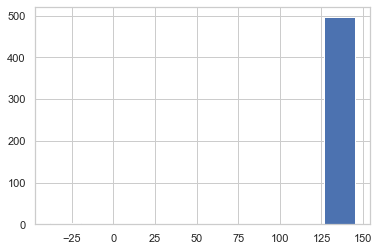

In [12]:
dirty_data_df['customer_lon'].hist(bins=10)

We can see that most of the longitude values are near the 144 degrees mark. But, few are near -37 degrees. This could be because **latitude and longitude were interchanged**.

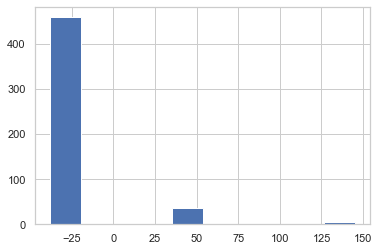

In [13]:
dirty_data_df['customer_lat'].hist(bins=10)

Here, again, we see the interchange issue between latitude and longitude. Further, we also see that there are many latitude values around positive 37 degrees. This could be input error where the **negative sign was not entered correctly**. 

## 2.2 Preliminary Set Up of Dataframe
This column is to keep track the changes made - so, at later points we need not work on rows where there have been corrections made. This is because we know that there is **only one anomaly per row**. <br>
Also, renaming `customerHasloyalty?` to `loyalty` for ease of use.

In [14]:
dirty_data_df['no_corrections'] = 0

In [15]:
dirty_data_df = dirty_data_df.rename(columns={"customerHasloyalty?":"loyalty"})

## 2.3 Correcting Data
### 2.3.1 Time and Date Format Errors

In [16]:
# split time into hours, minutes and seconds
coltitle = dirty_data_df['time'].apply(lambda s: pd.Series({'hour': s.split(':')[0].strip(),
                            'minute':s.split(':')[1].strip(), 'second':s.split(':')[2].strip()}))

# Add the columns to the dataframe
dirty_data_df = pd.concat([dirty_data_df, coltitle], axis=1) 
dirty_data_df['hour'] = dirty_data_df['hour'].astype(int)
dirty_data_df['minute'] = dirty_data_df['minute'].astype(int)
dirty_data_df['second'] = dirty_data_df['second'].astype(int)

dirty_data_df[['hour', 'minute', 'second']].describe()

,hour,minute,second
count,500.000000,500.000000,500.000000
mean,13.304000,28.388000,29.080000
std,3.577875,17.561385,17.046018
min,8.000000,0.000000,0.000000
25%,10.000000,13.000000,15.750000
50%,13.000000,28.000000,28.000000
75%,16.000000,43.000000,44.000000
max,20.000000,59.000000,59.000000


There seem to be no errors in the time format - we have 500 values in each of the three sections of time. Also, minutes and seconds both have a maxima of 59 and a minima of 00. Everything seems in order. <br>
We can move onto date formats.

In [17]:
# Split date into year, montha and date
coltitle = dirty_data_df['date'].apply(lambda s: pd.Series({'year': s.split('-')[0].strip(),
                            'month':s.split('-')[1].strip(), 'dat':s.split('-')[2].strip()}))

# Add the columns to the dataframe
dirty_data_df = pd.concat([dirty_data_df, coltitle], axis=1) 
dirty_data_df['year'] = dirty_data_df['year'].astype(int)
dirty_data_df['month'] = dirty_data_df['month'].astype(int)
dirty_data_df['dat'] = dirty_data_df['dat'].astype(int)

In [18]:
dirty_data_df[['year', 'month', 'dat']].describe()

,year,month,dat
count,500.000000,500.000000,500.00000
mean,1957.612000,6.958000,75.29400
std,343.725308,4.776806,342.10725
min,1.000000,1.000000,1.00000
25%,2018.000000,3.000000,8.00000
50%,2018.000000,7.000000,15.00000
75%,2018.000000,10.000000,24.00000
max,2018.000000,31.000000,2018.00000


Clearly, there is something wrong here. Minima for year is 1 and maxima for date is 2018. There seems to be atleast one observation where year and date are switched. <br>
There also are some values of months also that seem wrong. The maxima for months is 31. Again, this seems to be places where month and date is switched. 

In [19]:
len(dirty_data_df[dirty_data_df['year'] != 2018])

15

There are 15 rows where the date is in the wrong format. On inspection, we can see that in all instances, it's only the year and date that are switched around. Let's try to fix that. 

In [20]:
len(dirty_data_df[dirty_data_df['month'] > 12])

22

There are also 22 rows where the date and month are switched around. Let's try to fix that also. 

In [21]:
# define function to correct the date
def set_date_right(row):
    
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # correct the order - .dat contains year and .year contains date for these rows
    correct_date = str(row.dat) + "-" + str(row.month).zfill(2) + "-" + str(row.year).zfill(2) # pad 0s where necessary
    dirty_data_df.at[index, 'date'] = correct_date
    
    return None

# make the correction
dirty_data_df.loc[dirty_data_df['year'] != 2018, 'no_corrections'] = \
dirty_data_df.loc[dirty_data_df['year'] != 2018, 'no_corrections'].values + 1
dirty_data_df[dirty_data_df['year'] != 2018].apply(set_date_right, axis=1);

def set_month_right(row):
    
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # correct the order - .dat contains month and .month contains date for these rows
    correct_date = str(row.year) + "-" + str(row.dat).zfill(2) + "-" + str(row.month).zfill(2) # pad 0s where necessary
    dirty_data_df.at[index, 'date'] = correct_date
    
    return None

# make the correction
dirty_data_df.loc[dirty_data_df['month'] > 12, 'no_corrections'] = \
dirty_data_df.loc[dirty_data_df['month'] > 12, 'no_corrections'].values + 1
dirty_data_df[dirty_data_df['month'] > 12].apply(set_month_right, axis=1);

dirty_data_df[(dirty_data_df['year'] != 2018) | (dirty_data_df['month'] > 12)].head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,no_corrections,hour,minute,second,year,month,dat
6,ORDX05756,2018-06-01,12:54:05,Lunch,BK,"[('Fries', 7), ('Burger', 3), ('Chicken', 5), ...",806.80,-37.803059,144.950088,0,8.695,14.882052,1,12,54,5,1,6,2018
52,ORDK10027,2018-02-03,09:00:50,Breakfast,BK,"[('Eggs', 4), ('Pancake', 7), ('Coffee', 4)]",287.75,-37.823656,144.991144,0,6.099,13.840713,1,9,0,50,3,2,2018
61,ORDC08453,2018-12-27,20:00:00,Dinner,NS,"[('Salmon', 7), ('Fish&Chips', 7), ('Pasta', 3...",1100.50,-37.817191,144.932132,0,9.675,15.319584,1,20,0,0,2018,27,12
72,ORDK01918,2018-10-02,17:07:36,Dinner,BK,"[('Pasta', 9), ('Salmon', 6), ('Shrimp', 7), (...",1221.50,-37.802215,144.963357,0,7.841,14.756105,1,17,7,36,2,10,2018
83,ORDA06387,2018-10-27,17:58:18,Dinner,BK,"[('Pasta', 1), ('Fish&Chips', 1), ('Salmon', 7)]",349.50,-37.820705,144.990783,0,5.842,16.032959,1,17,58,18,2018,27,10


The date format issues are now fixed. All observations now have YYYY-MM-DD format.

### 2.3.2 Time and Order Type Mismatch

In [22]:
# check if there are errors in time and type
dirty_data_df[(dirty_data_df['time'].str.startswith('08:') |
               dirty_data_df['time'].str.startswith('09:') |
               dirty_data_df['time'].str.startswith('10:') |
               dirty_data_df['time'].str.startswith('11:')) &
              (dirty_data_df['order_type'] != 'Breakfast')].head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,no_corrections,hour,minute,second,year,month,dat
7,ORDJ01088,2018-01-24,08:40:33,Dinner,TP,"[('Eggs', 3), ('Cereal', 5), ('Coffee', 8), ('...",449.25,-37.803570,144.948088,0,9.942,12.218429,0,8,40,33,2018,1,24
44,ORDB04532,2018-03-11,10:11:49,Lunch,TP,"[('Cereal', 1), ('Coffee', 7)]",73.50,-37.803830,144.963397,0,9.319,13.048137,0,10,11,49,2018,3,11
106,ORDC08188,2018-03-21,10:32:06,Lunch,NS,"[('Eggs', 6), ('Cereal', 3)]",195.00,-37.812046,144.959457,0,7.968,12.856617,0,10,32,6,2018,3,21
158,ORDK03325,2018-02-04,09:00:50,Dinner,BK,"[('Eggs', 5), ('Pancake', 10), ('Cereal', 2)]",394.50,-37.802308,144.930172,0,10.663,18.179342,0,9,0,50,2018,2,4
195,ORDK04209,2018-04-17,11:32:57,Dinner,BK,"[('Eggs', 3), ('Pancake', 7), ('Coffee', 3), (...",426.25,-37.813292,144.973920,0,6.836,11.838531,0,11,32,57,2018,4,17


Clearly, there exists rows where the **time of the order and the type of the order does not match** with eachother. These can also be fixed easily

In [23]:
dirty_data_df[dirty_data_df['time'] == '12:00:00']

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,no_corrections,hour,minute,second,year,month,dat


In [24]:
dirty_data_df[dirty_data_df['time'] == '16:00:00']

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,no_corrections,hour,minute,second,year,month,dat


The edge cases of **exact 12:00:00 or 16:00:00 does not exist** in the dataset - so, we will not have to work around that. Might need more general method if those existed.

In [25]:
# track changes
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('08:') |
                   dirty_data_df['time'].str.startswith('09:') |
                   dirty_data_df['time'].str.startswith('10:') |
                   dirty_data_df['time'].str.startswith('11:')) &
                  (dirty_data_df['order_type'] != 'Breakfast'), 'no_corrections'] = \
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('08:') |
                   dirty_data_df['time'].str.startswith('09:') |
                   dirty_data_df['time'].str.startswith('10:') |
                   dirty_data_df['time'].str.startswith('11:')) &
                  (dirty_data_df['order_type'] != 'Breakfast'), 'no_corrections'].values + 1

# make correction with respect to time
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('08:') |
                   dirty_data_df['time'].str.startswith('09:') |
                   dirty_data_df['time'].str.startswith('10:') |
                   dirty_data_df['time'].str.startswith('11:')) &
                  (dirty_data_df['order_type'] != 'Breakfast'), 'order_type'] = 'Breakfast'

Doing the same for lunch and dinner as well.

In [26]:
# track changes
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('12:') |
                   dirty_data_df['time'].str.startswith('13:') |
                   dirty_data_df['time'].str.startswith('14:') |
                   dirty_data_df['time'].str.startswith('15:')) &
                  (dirty_data_df['order_type'] != 'Lunch'), 'no_corrections'] = \
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('12:') |
                   dirty_data_df['time'].str.startswith('13:') |
                   dirty_data_df['time'].str.startswith('14:') |
                   dirty_data_df['time'].str.startswith('15:')) &
                  (dirty_data_df['order_type'] != 'Lunch'), 'no_corrections'].values + 1

# make correction with respect to time
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('12:') |
                   dirty_data_df['time'].str.startswith('13:') |
                   dirty_data_df['time'].str.startswith('14:') |
                   dirty_data_df['time'].str.startswith('15:')) &
                  (dirty_data_df['order_type'] != 'Lunch'), 'order_type'] = 'Lunch'

In [27]:
# track changes
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('16:') |
                   dirty_data_df['time'].str.startswith('17:') |
                   dirty_data_df['time'].str.startswith('18:') |
                   dirty_data_df['time'].str.startswith('19:') |
                   dirty_data_df['time'].str.startswith('20:')) &
                  (dirty_data_df['order_type'] != 'Dinner'), 'no_corrections'] = \
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('16:') |
                   dirty_data_df['time'].str.startswith('17:') |
                   dirty_data_df['time'].str.startswith('18:') |
                   dirty_data_df['time'].str.startswith('19:') |
                   dirty_data_df['time'].str.startswith('20:')) &
                  (dirty_data_df['order_type'] != 'Dinner'), 'no_corrections'].values + 1

# make correction with respect to time
dirty_data_df.loc[(dirty_data_df['time'].str.startswith('16:') |
                   dirty_data_df['time'].str.startswith('17:') |
                   dirty_data_df['time'].str.startswith('18:') |
                   dirty_data_df['time'].str.startswith('19:') |
                   dirty_data_df['time'].str.startswith('20:')) &
                  (dirty_data_df['order_type'] != 'Dinner'), 'order_type'] = 'Dinner'

In [28]:
dirty_data_df = dirty_data_df.astype({"order_type": str})

### 2.3.3 Order Time and Order Items Mismatches
Now, we know that in outliers data there is no anomalies with respect to the items at different meal times. So, we use that information to inform our selection of items in each meal type. <br>
First, we make a column which lists all the items.

In [29]:
# create a duplicate copy of outliers data
outliers_dup_df = pd.read_csv("Group149_outlier_data.csv")

# define function to create a column for just the items
def get_items(row):
    matches = re.findall("\'(.*?)\'", row['order_items'])
    item_list = [x for x in matches]
    
    index = outliers_dup_df[outliers_dup_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    outliers_dup_df.at[index, 'item_names'] = item_list
    return item_list

# make the column
outliers_dup_df['item_names'] = ''
outliers_dup_df.apply(get_items, axis=1);

Next, we make a dataframe which makes a count of all items in each of the different time periods. 

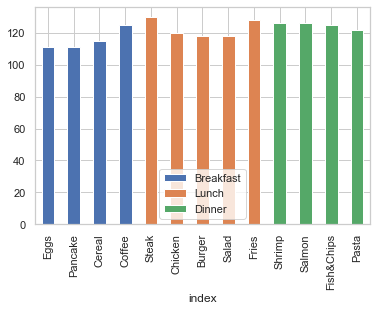

In [30]:
# dataframe of counts of items for breakfast
breakfast_item_list_non_flat = []
breakfast_df = outliers_dup_df[outliers_dup_df.order_type == 'Breakfast']
breakfast_item_list_non_flat = [(breakfast_item_list_non_flat + x) for x in breakfast_df.loc[:, 'item_names']]
breakfast_item_list = list(itertools.chain.from_iterable(breakfast_item_list_non_flat))
breakfast_counter = Counter(breakfast_item_list)
breakfast_count_list = [list(breakfast_counter.keys()), list(breakfast_counter.values())]
breakfast_item_count_df = pd.DataFrame(np.array(breakfast_count_list).T, columns=['Item','Breakfast'])
breakfast_item_count_df = breakfast_item_count_df.astype({"Breakfast": int})
breakfast_item_count_df = breakfast_item_count_df.set_index('Item')

# dataframe of counts of items for lunch
lunch_item_list_non_flat = []
lunch_df = outliers_dup_df[outliers_dup_df.order_type == 'Lunch']
lunch_item_list_non_flat = [(lunch_item_list_non_flat + x) for x in lunch_df.loc[:, 'item_names']]
lunch_item_list = list(itertools.chain.from_iterable(lunch_item_list_non_flat))
lunch_counter = Counter(lunch_item_list)
lunch_count_list = [list(lunch_counter.keys()), list(lunch_counter.values())]
lunch_item_count_df = pd.DataFrame(np.array(lunch_count_list).T, columns=['Item','Lunch'])
lunch_item_count_df = lunch_item_count_df.astype({"Lunch": int})
lunch_item_count_df = lunch_item_count_df.set_index('Item')

# dataframe of counts of items for dinner
dinner_item_list_non_flat = []
dinner_df = outliers_dup_df[outliers_dup_df.order_type == 'Dinner']
dinner_item_list_non_flat = [(dinner_item_list_non_flat + x) for x in dinner_df.loc[:, 'item_names']]
dinner_item_list = list(itertools.chain.from_iterable(dinner_item_list_non_flat))
dinner_counter = Counter(dinner_item_list)
dinner_count_list = [list(dinner_counter.keys()), list(dinner_counter.values())]
dinner_item_count_df = pd.DataFrame(np.array(dinner_count_list).T, columns=['Item','Dinner'])
dinner_item_count_df = dinner_item_count_df.astype({"Dinner": int})
dinner_item_count_df = dinner_item_count_df.set_index('Item')

# combine the dataframes
full_df = pd.concat([breakfast_item_count_df, lunch_item_count_df, dinner_item_count_df], axis = 1, sort = False)
full_df = full_df.fillna(0)
full_df.reset_index(inplace=True)

# plot the bar plot
full_df.plot(x = 'index', y = ["Breakfast", "Lunch", "Dinner"], kind="bar", stacked = True)

Clearly, we now know which items are available at the different meal times. Now, to find the mismatches.<br>
We first make a list of all items at each meal, then make a column in dirty data dataframe also for the items. Further, we find all the mismatches occuring by checking if all items in the order match with the order time. If there is even one mismatch, we **flag that as a mismatch**.

In [31]:
# get all unique items into a list
bf_items = list(set(breakfast_item_list))
ln_items = list(set(lunch_item_list))
dn_items = list(set(dinner_item_list))

In [32]:
# make the column for items (w/o counts)
def get_items(row):
    matches = re.findall("\'(.*?)\'", row['order_items'])
    item_list = [x for x in matches]
    
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    dirty_data_df.at[index, 'item_names'] = item_list
    return item_list

dirty_data_df['item_names'] = ''
dirty_data_df.apply(get_items, axis=1);

In [33]:
# initialise all columns to default values
dirty_data_df['item_time_mismatch'] = False
dirty_data_df['count_item_time_mismatch'] = 0

def get_item_time_mismatch(row):
    # initialise values
    mismatch_bool_list = []
    mismatch = False
    count = 0             # to get how many items are mismatched
    
    if row.order_type == "Breakfast":
        mismatch_bool_list = [False if (x in bf_items) else True for x in row.item_names]  # false for matching
        mismatch = any(mismatch_bool_list)                                 # if even one mismatch - make true
        count = sum(mismatch_bool_list)                                    # get a count of mismatches
    elif row.order_type == "Lunch":
        mismatch_bool_list = [False if (x in ln_items) else True for x in row.item_names]
        mismatch = any(mismatch_bool_list)
        count = sum(mismatch_bool_list)
    else:
        mismatch_bool_list = [False if (x in dn_items) else True for x in row.item_names]
        mismatch = any(mismatch_bool_list)
        count = sum(mismatch_bool_list)
    
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    dirty_data_df.at[index, 'item_time_mismatch'] = mismatch
    dirty_data_df.at[index, 'count_item_time_mismatch'] = count
    
    return None

dirty_data_df.apply(get_item_time_mismatch, axis=1);

We now have a flag for each row to indicate that there is a mismatch in time and order items. It can be fixed in two ways - a) by changing the time or b) by changing the item - we need to make a decision as to how.

In [34]:
dirty_data_df.count_item_time_mismatch.unique()

array([0, 1])

What we can see if that the **maximum number of mismatches is only 1** for any given observation. So, the better option would be to fix this by changing the item names. But, to do that, we need to know which item to substitute it by. This can be done by figuring out the prices of each of the items and using that in conjuction with the order price.

### 2.3.4 Price Calculation Issues
To get the right prices for each of the items as well, we will **use the data from outliers dataset** as we know for sure that all information in there is correct. We already have dataframes with each meal time made above. We will continue using that.<br>
We are now finding the counts of each of the items in the breakfast menu and adding that to columns in the same breakfast dataframe. <br>
Now, because these are copied dataframes, we get `SettingWithCopy` warnings. Because this is the intented behaviour, suppressing these warnings at this point. 

In [35]:
pd.set_option('mode.chained_assignment', None)                    # suppressing warnings

# initialise all to 0
breakfast_df['eggs'] = 0
breakfast_df['pancakes'] = 0
breakfast_df['cereal'] = 0
breakfast_df['coffee'] = 0

# define function to get count of items in breakfast
def get_bf_item_counts(row):    
    index = breakfast_df[breakfast_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    matches = re.findall("\'(.*?)\'\,\s(\d*)", row['order_items'])
    for match in matches:
        if match[0] == 'Eggs':
            breakfast_df.at[index, 'eggs'] = match[1]
        elif match[0] == 'Pancake':
            breakfast_df.at[index, 'pancakes'] = match[1]
        elif match[0] == 'Cereal':
            breakfast_df.at[index, 'cereal'] = match[1]
        elif match[0] == 'Coffee':
            breakfast_df.at[index, 'coffee'] = match[1]
    
    return None

breakfast_df.apply(get_bf_item_counts, axis = 1);
breakfast_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,item_names,eggs,pancakes,cereal,coffee
2,ORDK09812,2018-01-28,08:50:42,Breakfast,BK,"[('Eggs', 8), ('Pancake', 9), ('Cereal', 10), ...",679.25,-37.811478,144.938166,0,10.034,17.598874,"[Eggs, Pancake, Cereal, Coffee]",8,9,10,10
6,ORDJ05548,2018-04-30,11:53:14,Breakfast,TP,"[('Cereal', 2), ('Coffee', 1), ('Eggs', 8), ('...",298.25,-37.799874,144.955058,0,9.817,12.658981,"[Cereal, Coffee, Eggs, Pancake]",8,3,2,1
7,ORDX07952,2018-02-10,09:21:07,Breakfast,BK,"[('Eggs', 8), ('Pancake', 10)]",418.50,-37.807002,144.965690,0,7.187,14.600441,"[Eggs, Pancake]",8,10,0,0
11,ORDA09420,2018-04-20,11:32:57,Breakfast,BK,"[('Eggs', 5), ('Cereal', 8), ('Coffee', 2), ('...",438.50,-37.821030,144.955157,0,8.580,13.684439,"[Eggs, Cereal, Coffee, Pancake]",5,6,8,2
15,ORDY01566,2018-02-16,09:31:16,Breakfast,TP,"[('Eggs', 10), ('Coffee', 4), ('Cereal', 10)]",460.00,-37.807369,144.955906,0,9.250,11.720477,"[Eggs, Coffee, Cereal]",10,0,10,4


We have been able to get the appropriate output. The counts of the items in order are in new columns. <br><br>
Now, to use `numpy.linalg` to find the prices of each of the items.

In [36]:
# equations in 4 variables - so, we need 4 equations(rows) to be able to solve
row1 = breakfast_df.iloc[0]
row2 = breakfast_df.iloc[1]
row3 = breakfast_df.iloc[2]
row4 = breakfast_df.iloc[3]

a = np.array([[row1.eggs, row1.pancakes, row1.cereal, row1.coffee], 
              [row2.eggs, row2.pancakes, row2.cereal, row2.coffee], 
              [row3.eggs, row3.pancakes, row3.cereal, row3.coffee],
              [row4.eggs, row4.pancakes, row4.cereal, row4.coffee]])
b = np.array([row1.order_price, row2.order_price, row3.order_price, row4.order_price])

bf_prices = np.linalg.solve(a, b)
print(bf_prices)

[22.   24.25 21.    7.5 ]


Now, we'll do the same for lunch and dinner items as well.

In [37]:
# initialise all to 0
lunch_df['steak'] = 0
lunch_df['chicken'] = 0
lunch_df['burger'] = 0
lunch_df['salad'] = 0
lunch_df['fries'] = 0

# define function to get count of items in lunch
def get_ln_item_counts(row):    
    index = lunch_df[lunch_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    matches = re.findall("\'(.*?)\'\,\s(\d*)", row['order_items'])
    for match in matches:
        if match[0] == 'Steak':
            lunch_df.at[index, 'steak'] = match[1]
        elif match[0] == 'Chicken':
            lunch_df.at[index, 'chicken'] = match[1]
        elif match[0] == 'Burger':
            lunch_df.at[index, 'burger'] = match[1]
        elif match[0] == 'Salad':
            lunch_df.at[index, 'salad'] = match[1]
        elif match[0] == 'Fries':
            lunch_df.at[index, 'fries'] = match[1]
    
    return None

lunch_df.apply(get_ln_item_counts, axis = 1);

# equations in 5 variables - so, we need 5 equations(rows) to be able to solve
row1 = lunch_df.iloc[0]
row2 = lunch_df.iloc[1]
row3 = lunch_df.iloc[2]
row4 = lunch_df.iloc[3]
row5 = lunch_df.iloc[4]

a = np.array([[row1.steak, row1.chicken, row1.burger, row1.salad, row1.fries], 
              [row2.steak, row2.chicken, row2.burger, row2.salad, row2.fries],
              [row3.steak, row3.chicken, row3.burger, row3.salad, row3.fries],
              [row4.steak, row4.chicken, row4.burger, row4.salad, row4.fries], 
              [row5.steak, row5.chicken, row5.burger, row5.salad, row5.fries]])
b = np.array([row1.order_price, row2.order_price, row3.order_price, row4.order_price, row5.order_price])

ln_prices = np.linalg.solve(a, b)
print(ln_prices)

[45.  32.  31.  17.2 12. ]


In [38]:
# initialise all to 0
dinner_df['shrimp'] = 0
dinner_df['salmon'] = 0
dinner_df['f_chips'] = 0
dinner_df['pasta'] = 0

# define function to get count of items in breakfast
def get_dn_item_counts(row):    
    index = dinner_df[dinner_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    matches = re.findall("\'(.*?)\'\,\s(\d*)", row['order_items'])
    for match in matches:
        if match[0] == 'Shrimp':
            dinner_df.at[index, 'shrimp'] = match[1]
        elif match[0] == 'Salmon':
            dinner_df.at[index, 'salmon'] = match[1]
        elif match[0] == 'Fish&Chips':
            dinner_df.at[index, 'f_chips'] = match[1]
        elif match[0] == 'Pasta':
            dinner_df.at[index, 'pasta'] = match[1]
    
    return None

dinner_df.apply(get_dn_item_counts, axis = 1);

# equations in 4 variables - so, we need 4 equations(rows) to be able to solve
row1 = dinner_df.iloc[0]
row2 = dinner_df.iloc[1]
row3 = dinner_df.iloc[2]
row4 = dinner_df.iloc[3]

a = np.array([[row1.shrimp, row1.salmon, row1.f_chips, row1.pasta], 
              [row2.shrimp, row2.salmon, row2.f_chips, row2.pasta], 
              [row3.shrimp, row3.salmon, row3.f_chips, row3.pasta],
              [row4.shrimp, row4.salmon, row4.f_chips, row4.pasta]])
b = np.array([row1.order_price, row2.order_price, row3.order_price, row4.order_price])

dn_prices = np.linalg.solve(a, b)
print(dn_prices)

[54.  41.  35.  27.5]


Now that we have the prices of all the items, let us collate all of this information into a dataframe. 

In [39]:
prices_df = pd.DataFrame([])

# breakfast items
prices_df = pd.concat([prices_df, pd.DataFrame([['Eggs', bf_prices[0], 'Breakfast']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 
prices_df = pd.concat([prices_df, pd.DataFrame([['Pancake', bf_prices[1], 'Breakfast']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 
prices_df = pd.concat([prices_df, pd.DataFrame([['Cereal', bf_prices[2], 'Breakfast']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 
prices_df = pd.concat([prices_df, pd.DataFrame([['Coffee', bf_prices[3], 'Breakfast']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 

# lunch items
prices_df = pd.concat([prices_df, pd.DataFrame([['Steak', ln_prices[0], 'Lunch']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 
prices_df = pd.concat([prices_df, pd.DataFrame([['Chicken', ln_prices[1], 'Lunch']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 
prices_df = pd.concat([prices_df, pd.DataFrame([['Burger', ln_prices[2], 'Lunch']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 
prices_df = pd.concat([prices_df, pd.DataFrame([['Salad', ln_prices[3], 'Lunch']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 
prices_df = pd.concat([prices_df, pd.DataFrame([['Fries', ln_prices[4], 'Lunch']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True) 

# dinner items
prices_df = pd.concat([prices_df, pd.DataFrame([['Shrimp', dn_prices[0], 'Dinner']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True)
prices_df = pd.concat([prices_df, pd.DataFrame([['Salmon', dn_prices[1], 'Dinner']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True)
prices_df = pd.concat([prices_df, pd.DataFrame([['Fish&Chips', dn_prices[2], 'Dinner']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True)
prices_df = pd.concat([prices_df, pd.DataFrame([['Pasta', dn_prices[3], 'Dinner']], 
                                               columns = ['item', 'price', 'order_type'])], ignore_index = True)

prices_df

,item,price,order_type
0,Eggs,22.00,Breakfast
1,Pancake,24.25,Breakfast
2,Cereal,21.00,Breakfast
3,Coffee,7.50,Breakfast
4,Steak,45.00,Lunch
5,Chicken,32.00,Lunch
6,Burger,31.00,Lunch
7,Salad,17.20,Lunch
8,Fries,12.00,Lunch
9,Shrimp,54.00,Dinner


The prices dataframe seems to be well built. We can use this for later analysis.<br>
Also, stopping the suppression of `SettingWithCopy` at this point.

In [40]:
pd.set_option('mode.chained_assignment', 'warn')

### 2.3.5 Fixing Time and Item Mismatch Issues

In [41]:
# initialise all to 0
dirty_data_df['eggs'] = 0
dirty_data_df['pancakes'] = 0
dirty_data_df['cereal'] = 0
dirty_data_df['coffee'] = 0
dirty_data_df['steak'] = 0
dirty_data_df['chicken'] = 0
dirty_data_df['burger'] = 0
dirty_data_df['salad'] = 0
dirty_data_df['fries'] = 0
dirty_data_df['shrimp'] = 0
dirty_data_df['salmon'] = 0
dirty_data_df['f_chips'] = 0
dirty_data_df['pasta'] = 0
dirty_data_df['calc_price'] = 0.0

# define function to get count of items in breakfast
def get_item_counts(row):    
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    matches = re.findall("\'(.*?)\'\,\s(\d*)", row['order_items'])
    for match in matches:
        if match[0] == 'Eggs':
            dirty_data_df.at[index, 'eggs'] = match[1]
        elif match[0] == 'Pancake':
            dirty_data_df.at[index, 'pancakes'] = match[1]
        elif match[0] == 'Cereal':
            dirty_data_df.at[index, 'cereal'] = match[1]
        elif match[0] == 'Coffee':
            dirty_data_df.at[index, 'coffee'] = match[1]
        elif match[0] == 'Steak':
            dirty_data_df.at[index, 'steak'] = match[1]
        elif match[0] == 'Chicken':
            dirty_data_df.at[index, 'chicken'] = match[1]
        elif match[0] == 'Burger':
            dirty_data_df.at[index, 'burger'] = match[1]
        elif match[0] == 'Salad':
            dirty_data_df.at[index, 'salad'] = match[1]
        elif match[0] == 'Fries':
            dirty_data_df.at[index, 'fries'] = match[1]
        elif match[0] == 'Shrimp':
            dirty_data_df.at[index, 'shrimp'] = match[1]
        elif match[0] == 'Salmon':
            dirty_data_df.at[index, 'salmon'] = match[1]
        elif match[0] == 'Fish&Chips':
            dirty_data_df.at[index, 'f_chips'] = match[1]
        elif match[0] == 'Pasta':
            dirty_data_df.at[index, 'pasta'] = match[1]
    
    cal_price = (dirty_data_df.loc[index, 'eggs'] * float(prices_df.loc[prices_df.item == "Eggs", 'price'])) + \
                (dirty_data_df.loc[index, 'pancakes'] * float(prices_df.loc[prices_df.item == "Pancake", 'price'])) + \
                (dirty_data_df.loc[index, 'cereal'] * float(prices_df.loc[prices_df.item == "Cereal", 'price'])) + \
                (dirty_data_df.loc[index, 'coffee'] * float(prices_df.loc[prices_df.item == "Coffee", 'price'])) + \
                (dirty_data_df.loc[index, 'steak'] * float(prices_df.loc[prices_df.item == "Steak", 'price'])) + \
                (dirty_data_df.loc[index, 'chicken'] * float(prices_df.loc[prices_df.item == "Chicken", 'price'])) + \
                (dirty_data_df.loc[index, 'burger'] * float(prices_df.loc[prices_df.item == "Burger", 'price'])) + \
                (dirty_data_df.loc[index, 'salad'] * float(prices_df.loc[prices_df.item == "Salad", 'price'])) + \
                (dirty_data_df.loc[index, 'fries'] * float(prices_df.loc[prices_df.item == "Fries", 'price'])) + \
                (dirty_data_df.loc[index, 'shrimp'] * float(prices_df.loc[prices_df.item == "Shrimp", 'price'])) + \
                (dirty_data_df.loc[index, 'salmon'] * float(prices_df.loc[prices_df.item == "Salmon", 'price'])) + \
                (dirty_data_df.loc[index, 'f_chips'] * float(prices_df.loc[prices_df.item == "Fish&Chips", 'price'])) + \
                (dirty_data_df.loc[index, 'pasta'] * float(prices_df.loc[prices_df.item == "Pasta", 'price']))
    
    cal_price = round(cal_price, 2)
    dirty_data_df.at[index, 'calc_price'] = cal_price
    
    return None

dirty_data_df.apply(get_item_counts, axis = 1);
dirty_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,steak,chicken,burger,salad,fries,shrimp,salmon,f_chips,pasta,calc_price
0,ORDX07870,2018-11-13,18:28:43,Dinner,BK,"[('Shrimp', 9), ('Fish&Chips', 8), ('Pasta', 2)]",821.0,37.820999,144.943166,0,...,0,0,0,0,0,9,0,8,2,821.0
1,ORDK07313,2018-10-22,17:48:10,Dinner,BK,"[('Fish&Chips', 3), ('Salmon', 8), ('Shrimp', 8)]",865.0,-37.820072,144.982469,0,...,0,0,0,0,0,8,8,3,0,865.0
2,ORDJ02466,2018-01-27,08:50:42,Breakfast,TP,"[('Pancake', 6), ('Coffee', 8), ('Cereal', 9),...",675.4,-37.809265,144.931906,0,...,0,0,0,0,0,0,0,0,0,526.5
3,ORDA04640,2018-05-29,12:54:05,Lunch,BK,"[('Fries', 5), ('Chicken', 10), ('Salad', 6), ...",576.2,-37.804384,144.930085,0,...,0,10,3,6,5,0,0,0,0,576.2
4,ORDC06764,2018-04-16,11:22:49,Breakfast,NS,"[('Coffee', 3), ('Cereal', 9), ('Pancake', 6)]",357.0,37.811042,144.966105,0,...,0,0,0,0,0,0,0,0,0,357.0


In [42]:
len(dirty_data_df[dirty_data_df.order_price != dirty_data_df.calc_price])

74

In [43]:
len(dirty_data_df[dirty_data_df.item_time_mismatch])

37

Here, we see that there are **37 rows** where the time and items are mismatched, but a total of **74 rows** where there is mismatch between the calculated price and stated price. <br>
We can fix the item and time mismatch by changing items. But, the price and item mismatch would probably have to be fixed by changing the order price. Since **the fixes might be different for the two cases**, we will consider these separately. We will attempt to fix the price and item mismatch later. For now, **looking at the time and item mismatch.**<br>
We only need consider the rows where the time item mismatch flag is set to true.

In [44]:
dirty_data_df[dirty_data_df.item_time_mismatch].head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,steak,chicken,burger,salad,fries,shrimp,salmon,f_chips,pasta,calc_price
21,ORDZ01499,2018-01-12,08:20:16,Breakfast,NS,"[('Pancake', 9), ('Steak', 2), ('Coffee', 8)]",322.25,-37.798971,144.970709,1,...,2,0,0,0,0,0,0,0,0,368.25
26,ORDJ02910,2018-04-12,11:22:49,Breakfast,TP,"[('Fries', 4), ('Eggs', 10)]",250.00,-37.814123,144.962308,0,...,0,0,0,0,4,0,0,0,0,268.00
34,ORDJ08687,2018-01-09,08:10:08,Breakfast,TP,"[('Eggs', 6), ('Pancake', 2), ('Cereal', 3), (...",311.00,-37.802592,144.980063,1,...,0,0,0,9,0,0,0,0,0,398.30
54,ORDA05709,2018-12-19,19:39:43,Dinner,BK,"[('Fish&Chips', 8), ('Cereal', 9)]",766.00,-37.814337,144.935910,0,...,0,0,0,0,0,0,0,8,0,469.00
62,ORDB00439,2018-06-28,13:54:55,Lunch,TP,"[('Pasta', 8), ('Fries', 9), ('Salad', 2), ('S...",525.40,-37.812921,144.991312,0,...,3,0,0,2,9,0,0,0,8,497.40


In [45]:
def set_right_item(row):    
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # find which item is mismatched
    mismatched_item = ""
    if row.order_type == "Breakfast":
        mismatched_item = [item for item in row.item_names if item not in bf_items][0]
    elif row.order_type == "Lunch":
        mismatched_item = [item for item in row.item_names if item not in ln_items][0]
    elif row.order_type == "Dinner":
        mismatched_item = [item for item in row.item_names if item not in dn_items][0]
    
    # next find the count of that item
    matches = re.search(re.escape(mismatched_item) + "\'\,\s(\d*)", row['order_items'])
    count_of_mismatched_item = matches.group(1)
    
    # get a sum of all the corrrect items
    sum_correct_items = 0.0
    if row.order_type == "Breakfast":
        sum_correct_items = (dirty_data_df.loc[index, 'eggs'] * float(prices_df.loc[prices_df.item == "Eggs", 'price'])) + \
                            (dirty_data_df.loc[index, 'pancakes'] * float(prices_df.loc[prices_df.item == "Pancake", 'price'])) + \
                            (dirty_data_df.loc[index, 'cereal'] * float(prices_df.loc[prices_df.item == "Cereal", 'price'])) + \
                            (dirty_data_df.loc[index, 'coffee'] * float(prices_df.loc[prices_df.item == "Coffee", 'price']))
    elif row.order_type == "Lunch":
        sum_correct_items = (dirty_data_df.loc[index, 'steak'] * float(prices_df.loc[prices_df.item == "Steak", 'price'])) + \
                            (dirty_data_df.loc[index, 'chicken'] * float(prices_df.loc[prices_df.item == "Chicken", 'price'])) + \
                            (dirty_data_df.loc[index, 'burger'] * float(prices_df.loc[prices_df.item == "Burger", 'price'])) + \
                            (dirty_data_df.loc[index, 'salad'] * float(prices_df.loc[prices_df.item == "Salad", 'price'])) + \
                            (dirty_data_df.loc[index, 'fries'] * float(prices_df.loc[prices_df.item == "Fries", 'price']))
    elif row.order_type == "Dinner":
        sum_correct_items = (dirty_data_df.loc[index, 'shrimp'] * float(prices_df.loc[prices_df.item == "Shrimp", 'price'])) + \
                            (dirty_data_df.loc[index, 'salmon'] * float(prices_df.loc[prices_df.item == "Salmon", 'price'])) + \
                            (dirty_data_df.loc[index, 'f_chips'] * float(prices_df.loc[prices_df.item == "Fish&Chips", 'price'])) + \
                            (dirty_data_df.loc[index, 'pasta'] * float(prices_df.loc[prices_df.item == "Pasta", 'price']))
    
    sum_correct_items = round(sum_correct_items, 2)
    
    # difference between given price and price of only the right items
    difference_in_price = round(row.order_price - sum_correct_items, 2)         
    price_correct_item = round((difference_in_price/float(count_of_mismatched_item)), 2)    # price of the right item
    
    # find right item using the price we found
    correct_item = str(prices_df.loc[round(prices_df.price, 2) == round(price_correct_item, 2), 'item'])
    correct_item_match = re.search("(?:\d*)\s*(.*)\s*Name", correct_item)
    correct_item = correct_item_match.group(1)
    
    # replace wrong item with correct item
    text = re.sub(re.escape(mismatched_item), re.escape(correct_item), row.order_items)  
    text = re.sub("\\\\", "", text)                        # remove backslashes
    dirty_data_df.at[index, 'order_items'] = text

    return None

dirty_data_df[dirty_data_df.item_time_mismatch].apply(set_right_item, axis = 1);
dirty_data_df[dirty_data_df.item_time_mismatch].head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,steak,chicken,burger,salad,fries,shrimp,salmon,f_chips,pasta,calc_price
21,ORDZ01499,2018-01-12,08:20:16,Breakfast,NS,"[('Pancake', 9), ('Eggs', 2), ('Coffee', 8)]",322.25,-37.798971,144.970709,1,...,2,0,0,0,0,0,0,0,0,368.25
26,ORDJ02910,2018-04-12,11:22:49,Breakfast,TP,"[('Coffee', 4), ('Eggs', 10)]",250.00,-37.814123,144.962308,0,...,0,0,0,0,4,0,0,0,0,268.00
34,ORDJ08687,2018-01-09,08:10:08,Breakfast,TP,"[('Eggs', 6), ('Pancake', 2), ('Cereal', 3), (...",311.00,-37.802592,144.980063,1,...,0,0,0,9,0,0,0,0,0,398.30
54,ORDA05709,2018-12-19,19:39:43,Dinner,BK,"[('Fish&Chips', 8), ('Shrimp', 9)]",766.00,-37.814337,144.935910,0,...,0,0,0,0,0,0,0,8,0,469.00
62,ORDB00439,2018-06-28,13:54:55,Lunch,TP,"[('Burger', 8), ('Fries', 9), ('Salad', 2), ('...",525.40,-37.812921,144.991312,0,...,3,0,0,2,9,0,0,0,8,497.40


The items now appear corrected for the rows where time and items were mismatched. <br>

In [46]:
# all non breakfast items to 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'steak'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'chicken'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'burger'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'salad'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'fries'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'shrimp'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'salmon'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'f_chips'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Breakfast'), 'pasta'] = 0

# all non lunch items to 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Lunch'), 'eggs'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Lunch'), 'pancakes'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Lunch'), 'cereal'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Lunch'), 'coffee'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Lunch'), 'shrimp'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Lunch'), 'salmon'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Lunch'), 'f_chips'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Lunch'), 'pasta'] = 0

# all non dinner items to 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'eggs'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'pancakes'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'cereal'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'coffee'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'steak'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'chicken'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'burger'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'salad'] = 0
dirty_data_df.loc[dirty_data_df.item_time_mismatch & (dirty_data_df.order_type == 'Dinner'), 'fries'] = 0

# recalculate prices for these rows
dirty_data_df[dirty_data_df.item_time_mismatch].apply(get_item_counts, axis = 1);

# update that corrections were made here
dirty_data_df.loc[dirty_data_df.item_time_mismatch, 'no_corrections'] = \
dirty_data_df.loc[dirty_data_df.item_time_mismatch, 'no_corrections'].values + 1

len(dirty_data_df[(dirty_data_df.order_price != dirty_data_df.calc_price) & dirty_data_df.item_time_mismatch])

0

We also fix the calculated price for those rows which **had** time and item mismatch. The rows with mismatch in calculated and given prices is now 0 for the rows which **had** time and item mismatch. 

### 2.3.6 Fixing Item and Price Mismatch Issues
Now, moving on to the observations where price and items (calculated price) mismatch. There should now be 37 of these rows (74 minus 37).

In [47]:
len(dirty_data_df[dirty_data_df.order_price != dirty_data_df.calc_price])

37

In [48]:
dirty_data_df[(dirty_data_df.order_id == "ORDB04440") | (dirty_data_df.order_id == "ORDI08916")]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,steak,chicken,burger,salad,fries,shrimp,salmon,f_chips,pasta,calc_price
105,ORDB04440,2018-10-07,17:17:44,Dinner,TP,"[('Salmon', 9), ('Pasta', 10), ('Shrimp', 2), ...",620.80,-37.819799,144.961298,0,...,0,0,0,0,0,2,9,5,10,927.0
140,ORDI08916,2018-08-27,15:56:37,Lunch,NS,"[('Burger', 7), ('Steak', 5)]",87.75,-37.802675,144.982423,0,...,5,0,7,0,0,0,0,0,0,442.0


From the above observations, we see that the wrong order price is ending with 80 cents in the case of dinner in the first observation and with 75 cents in case for lunch for second observations. Now, having a look at the prices of items in lunch and dinner, we can conclude that **no combination of the items would end up costing the same as the given order price**. Therefore, the fix must be on the price side and not on the items side. <br>
This makes the fix much easier. All we need to do is change the order price to the calculated price.

In [49]:
def fix_right_price(row):    
    
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    dirty_data_df.at[index, 'order_price'] = row.calc_price
    
    return None

dirty_data_df.loc[dirty_data_df.order_price != dirty_data_df.calc_price, 'no_corrections'] = \
dirty_data_df.loc[dirty_data_df.order_price != dirty_data_df.calc_price, 'no_corrections'].values + 1   # update correction
dirty_data_df[dirty_data_df.order_price != dirty_data_df.calc_price].apply(fix_right_price, axis = 1);

len(dirty_data_df[dirty_data_df.order_price != dirty_data_df.calc_price])

0

The price and item mismatch is also now fixed. The number of rows with mismatch is now 0 (obviously - we just copied one to the other). 

### 2.3.7 Fixing Latitude and Longitude Issues

We saw in the exploratory analysis that there are few latitude and longitude values that seem suspicious. Some of the latitude and longitude values seem to be interchanged. Also, some of the latitude values also seem to have wrongly entered with positive values instead of negative. Let us correct these.

In [50]:
dirty_data_df[dirty_data_df['customer_lon'] < 0]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,steak,chicken,burger,salad,fries,shrimp,salmon,f_chips,pasta,calc_price
30,ORDI10293,2018-12-26,19:49:51,Dinner,NS,"[('Fish&Chips', 10), ('Salmon', 10)]",760.0,144.999925,-37.811872,0,...,0,0,0,0,0,0,10,10,0,760.0
137,ORDJ09824,2018-09-19,16:37:10,Dinner,TP,"[('Shrimp', 1), ('Fish&Chips', 5), ('Pasta', 5)]",366.5,144.929081,-37.825471,0,...,0,0,0,0,0,1,0,5,5,366.5
291,ORDY06264,2018-06-26,13:44:47,Lunch,TP,"[('Burger', 7), ('Fries', 4), ('Salad', 5)]",351.0,144.956764,-37.822144,0,...,0,0,7,5,4,0,0,0,0,351.0
497,ORDB02862,2018-10-12,17:27:53,Dinner,TP,"[('Salmon', 2), ('Fish&Chips', 4), ('Shrimp', ...",874.0,144.984788,-37.823971,0,...,0,0,0,0,0,8,2,4,8,874.0


The above four rows have latitude and longitude mixed up. Correcting those first.

In [51]:
dirty_data_df.loc[dirty_data_df['customer_lon'] < 0, 'no_corrections'] = \
dirty_data_df.loc[dirty_data_df['customer_lon'] < 0, 'no_corrections'].values + 1        # track corrections
# swap longitude and latitude values
dirty_data_df.loc[dirty_data_df['customer_lon'] < 0,['customer_lon', 'customer_lat']] = \
dirty_data_df.loc[dirty_data_df['customer_lon'] < 0,['customer_lat', 'customer_lon']].values

dirty_data_df[dirty_data_df['customer_lon'] < 0]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,steak,chicken,burger,salad,fries,shrimp,salmon,f_chips,pasta,calc_price


Those have now been corrected. Now, moving on to the issues where there are positive values in latitude.

In [52]:
dirty_data_df[dirty_data_df['customer_lat'] > 0]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,steak,chicken,burger,salad,fries,shrimp,salmon,f_chips,pasta,calc_price
0,ORDX07870,2018-11-13,18:28:43,Dinner,BK,"[('Shrimp', 9), ('Fish&Chips', 8), ('Pasta', 2)]",821.00,37.820999,144.943166,0,...,0,0,0,0,0,9,0,8,2,821.00
4,ORDC06764,2018-04-16,11:22:49,Breakfast,NS,"[('Coffee', 3), ('Cereal', 9), ('Pancake', 6)]",357.00,37.811042,144.966105,0,...,0,0,0,0,0,0,0,0,0,357.00
12,ORDB01063,2018-12-15,19:29:34,Dinner,TP,"[('Shrimp', 4), ('Fish&Chips', 10), ('Salmon',...",949.50,37.808965,144.970818,0,...,0,0,0,0,0,4,6,10,5,949.50
24,ORDZ08773,2018-10-06,17:07:36,Dinner,NS,"[('Shrimp', 10), ('Salmon', 5)]",745.00,37.822654,144.977843,0,...,0,0,0,0,0,10,5,0,0,745.00
110,ORDX06335,2018-10-10,17:17:44,Dinner,BK,"[('Salmon', 8), ('Fish&Chips', 1), ('Shrimp', 4)]",579.00,37.809860,144.928936,0,...,0,0,0,0,0,4,8,1,0,579.00
132,ORDB10688,2018-09-22,16:47:19,Dinner,TP,"[('Shrimp', 2), ('Fish&Chips', 1)]",143.00,37.804280,144.992849,0,...,0,0,0,0,0,2,0,1,0,143.00
139,ORDA04670,2018-10-26,17:48:10,Dinner,BK,"[('Salmon', 7), ('Shrimp', 5), ('Fish&Chips', 9)]",872.00,37.806914,144.998466,0,...,0,0,0,0,0,5,7,9,0,872.00
149,ORDA04281,2018-11-27,18:59:09,Dinner,BK,"[('Fish&Chips', 5), ('Pasta', 3), ('Salmon', 1...",829.50,37.815935,144.982433,0,...,0,0,0,0,0,3,10,5,3,829.50
155,ORDY04048,2018-06-02,13:04:13,Lunch,TP,"[('Salad', 9), ('Fries', 4)]",202.80,37.801301,144.993872,0,...,0,0,0,9,4,0,0,0,0,202.80
167,ORDK01911,2018-04-01,10:52:23,Breakfast,BK,"[('Pancake', 8), ('Cereal', 1)]",215.00,37.816063,144.952952,0,...,0,0,0,0,0,0,0,0,0,215.00


In [53]:
dirty_data_df.loc[dirty_data_df['customer_lat'] > 0, 'no_corrections'] = \
dirty_data_df.loc[dirty_data_df['customer_lat'] > 0, 'no_corrections'].values + 1       # track changes
# make the positive values negative
dirty_data_df.loc[dirty_data_df['customer_lat'] > 0, 'customer_lat'] = \
-1 * dirty_data_df.loc[dirty_data_df['customer_lat'] > 0, 'customer_lat'].values

dirty_data_df[dirty_data_df['customer_lat'] > 0]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,steak,chicken,burger,salad,fries,shrimp,salmon,f_chips,pasta,calc_price


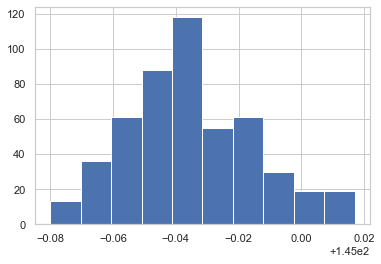

In [54]:
dirty_data_df['customer_lon'].hist(bins=10)

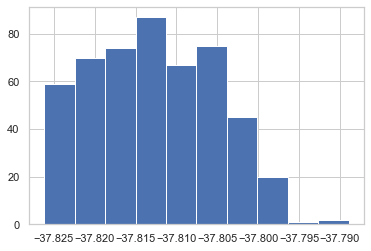

In [55]:
dirty_data_df['customer_lat'].hist(bins=10)

The latitude and longitude issues seem to be fixed at this point - all the datapoints are now clustered aroud the expected values. We can now find out the customer nodes of all these orders for later sections.

In [56]:
dirty_data_df['customer_node'] = 0

def get_customer_node(row):
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set up the customer node where available
    customer_node = nodes_df[(nodes_df.lat == row['customer_lat']) 
                   & (nodes_df.lon == row['customer_lon'])].node
    
    if (len(customer_node) == 1):
        dirty_data_df.at[index, 'customer_node'] = customer_node 
            
    return None

# make the column
dirty_data_df.apply(get_customer_node, axis = 1);

### 2.3.8 Correcting Branch Codes
In this section, we attempt to fix issues with the branch code. Let us look at outliers data again to see if we can spot any patterns with the three branches. This is because we know that all the data there regarding branches is correct and we only have anomalies in the delivery fee column. 

In [57]:
outliers_dup_df['init_order_id'] = outliers_dup_df['order_id'].str[:4]       # new column with only first 4 letters
outliers_dup_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,item_names,init_order_id
0,ORDX10841,2018-09-27,16:57:27,Dinner,BK,"[('Shrimp', 8), ('Salmon', 4), ('Fish&Chips', ...",998.50,-37.803562,144.945311,0,9.148,8.253948,"[Shrimp, Salmon, Fish&Chips, Pasta]",ORDX
1,ORDZ06960,2018-06-15,13:24:30,Lunch,NS,"[('Steak', 9), ('Chicken', 10)]",725.00,-37.818733,145.015963,0,11.866,17.386152,"[Steak, Chicken]",ORDZ
2,ORDK09812,2018-01-28,08:50:42,Breakfast,BK,"[('Eggs', 8), ('Pancake', 9), ('Cereal', 10), ...",679.25,-37.811478,144.938166,0,10.034,17.598874,"[Eggs, Pancake, Cereal, Coffee]",ORDK
3,ORDJ11099,2018-11-11,18:28:43,Dinner,TP,"[('Salmon', 5), ('Fish&Chips', 1), ('Shrimp', ...",567.00,-37.818288,144.946777,0,9.283,15.149030,"[Salmon, Fish&Chips, Shrimp, Pasta]",ORDJ
4,ORDA10794,2018-08-06,15:05:54,Lunch,BK,"[('Chicken', 10), ('Steak', 8), ('Burger', 7),...",1000.20,-37.811975,144.965722,0,7.447,13.247658,"[Chicken, Steak, Burger, Salad]",ORDA


Here, we have created a new column which has only the first 4 letters from the order IDs. These seem to be showing some patterns. Let us investigate further with some visualisations. 

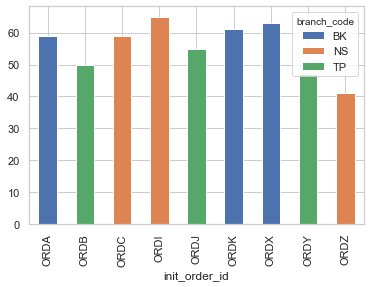

In [58]:
count_df = pd.crosstab(outliers_dup_df.init_order_id, outliers_dup_df.branch_code)
count_df.plot(kind='bar', stacked=True)

As we can see from here, the **order IDs are unique to the branches**. Branch BK as order IDs starting with ORDA, ORDK and ORDX. Branch NS has order IDs starting with ORDC, ORDI and ORDZ. Finally, branch TP has order IDs starting with ORDB, ORDJ and ORDY. <br>
We can leverage this information to correct the branch codes in the dirty data.

In [59]:
def check_branch_mismatch(row):
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    if ((((row.init_order_id == "ORDA") or (row.init_order_id == "ORDK") or (row.init_order_id == "ORDX")) 
       and row.branch_code != "BK") or 
       (((row.init_order_id == "ORDC") or (row.init_order_id == "ORDI") or (row.init_order_id == "ORDZ")) 
       and row.branch_code != "NS") or 
       (((row.init_order_id == "ORDB") or (row.init_order_id == "ORDJ") or (row.init_order_id == "ORDY")) 
       and row.branch_code != "TP")):
        dirty_data_df.at[index, 'branch_mismatch'] = True

    return None

dirty_data_df['init_order_id'] = dirty_data_df['order_id'].str[:4]
dirty_data_df['branch_mismatch'] = False
dirty_data_df.apply(check_branch_mismatch, axis=1);

dirty_data_df[dirty_data_df.branch_mismatch].head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,salad,fries,shrimp,salmon,f_chips,pasta,calc_price,customer_node,init_order_id,branch_mismatch
25,ORDC04728,2018-02-23,09:41:24,Breakfast,tp,"[('Eggs', 3), ('Pancake', 8), ('Coffee', 5)]",297.5,-37.806624,144.932333,0,...,0,0,0,0,0,0,297.5,3106293381,ORDC,True
32,ORDC01152,2018-08-29,15:56:37,Lunch,BK,"[('Chicken', 2), ('Steak', 2), ('Burger', 6), ...",424.0,-37.817452,144.945663,0,...,0,7,0,0,0,0,424.0,1132023823,ORDC,True
46,ORDK08083,2018-03-09,10:11:49,Breakfast,TP,"[('Coffee', 1), ('Cereal', 5)]",112.5,-37.807498,144.962891,0,...,0,0,0,0,0,0,112.5,2183290186,ORDK,True
48,ORDZ00905,2018-08-22,15:46:28,Lunch,tp,"[('Fries', 8), ('Burger', 7)]",313.0,-37.809117,144.936871,0,...,0,8,0,0,0,0,313.0,641026085,ORDZ,True
59,ORDZ07671,2018-03-31,10:52:23,Breakfast,BK,"[('Coffee', 2), ('Eggs', 4)]",103.0,-37.807320,144.958225,0,...,0,0,0,0,0,0,103.0,711358620,ORDZ,True


The above was done without immediately applying correction just to get a count of the number of mismatches. The count will help in making sure that we are not making multiple corrections on the same row.<br>
Now, onto fixing the mistakes. 

In [60]:
def fix_branch_mismatch(row):
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set the branch code according to pattern in the order IDs
    if ((row.init_order_id == "ORDA") or (row.init_order_id == "ORDK") or (row.init_order_id == "ORDX")):
        dirty_data_df.at[index, 'branch_code'] = "BK"
    elif ((row.init_order_id == "ORDC") or (row.init_order_id == "ORDI") or (row.init_order_id == "ORDZ")):
        dirty_data_df.at[index, 'branch_code'] = "NS"
    elif ((row.init_order_id == "ORDB") or (row.init_order_id == "ORDJ") or (row.init_order_id == "ORDY")):
        dirty_data_df.at[index, 'branch_code'] = "TP"

    return None

dirty_data_df[dirty_data_df.branch_mismatch].apply(fix_branch_mismatch, axis = 1);
dirty_data_df.loc[dirty_data_df.branch_mismatch, 'no_corrections'] = \
dirty_data_df.loc[dirty_data_df.branch_mismatch, 'no_corrections'].values + 1          # track changes

In [61]:
dirty_data_df

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,salad,fries,shrimp,salmon,f_chips,pasta,calc_price,customer_node,init_order_id,branch_mismatch
0,ORDX07870,2018-11-13,18:28:43,Dinner,BK,"[('Shrimp', 9), ('Fish&Chips', 8), ('Pasta', 2)]",821.0,-37.820999,144.943166,0,...,0,0,9,0,8,2,821.0,3810637328,ORDX,False
1,ORDK07313,2018-10-22,17:48:10,Dinner,BK,"[('Fish&Chips', 3), ('Salmon', 8), ('Shrimp', 8)]",865.0,-37.820072,144.982469,0,...,0,0,8,8,3,0,865.0,575379896,ORDK,False
2,ORDJ02466,2018-01-27,08:50:42,Breakfast,TP,"[('Pancake', 6), ('Coffee', 8), ('Cereal', 9),...",526.5,-37.809265,144.931906,0,...,0,0,0,0,0,0,526.5,30286983,ORDJ,False
3,ORDA04640,2018-05-29,12:54:05,Lunch,BK,"[('Fries', 5), ('Chicken', 10), ('Salad', 6), ...",576.2,-37.804384,144.930085,0,...,6,5,0,0,0,0,576.2,581751028,ORDA,False
4,ORDC06764,2018-04-16,11:22:49,Breakfast,NS,"[('Coffee', 3), ('Cereal', 9), ('Pancake', 6)]",357.0,-37.811042,144.966105,0,...,0,0,0,0,0,0,357.0,6167236662,ORDC,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORDI06200,2018-06-07,13:14:21,Lunch,NS,"[('Salad', 1), ('Burger', 1), ('Steak', 3)]",183.2,-37.815476,144.946207,1,...,1,0,0,0,0,0,183.2,377544302,ORDI,False
496,ORDY06247,2018-09-16,16:37:10,Dinner,TP,"[('Fish&Chips', 10), ('Salmon', 2), ('Shrimp',...",675.5,-37.804011,144.982194,0,...,0,0,4,2,10,1,675.5,224750302,ORDY,False
497,ORDB02862,2018-10-12,17:27:53,Dinner,TP,"[('Salmon', 2), ('Fish&Chips', 4), ('Shrimp', ...",874.0,-37.823971,144.984788,0,...,0,0,8,2,4,8,874.0,1449496101,ORDB,False
498,ORDJ04208,2018-08-23,15:46:28,Lunch,TP,"[('Burger', 3), ('Fries', 4), ('Salad', 7)]",261.4,-37.817906,144.970640,0,...,7,4,0,0,0,0,261.4,247417091,ORDJ,False


This would now have fixed all the branch name mismatches. We can now think about the mistakes in distances of the customers from the branch ordered from.

### 2.3.9 Correcting Branch and Distance Mismatch
Now that we have the customer nodes of all the orders calculated from the latitude and longitude, we can check if there are any observations where the coordinates and the distance to the customer from the branch do not match up.<br>
As a first step let us flag all of the rows where there is a mismatch.

In [62]:
def check_branch_dist_mismatch(row):
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    dist = 0.0
    
    # find shortest distance according to the branch
    if row.branch_code.upper() == "NS":
        dist = nx.shortest_path_length(G, row.customer_node, NS_node.iloc[0], 'distance(m)')
    elif row.branch_code.upper() == "TP":
        dist = nx.shortest_path_length(G, row.customer_node, TP_node.iloc[0], 'distance(m)')
    elif row.branch_code.upper() == "BK":
        dist = nx.shortest_path_length(G, row.customer_node, BK_node.iloc[0], 'distance(m)')
    
    dist = round((dist/1000), 3)
    if (dist != round(row.distance_to_customer_KM, 3)):
        dirty_data_df.at[index, 'branch_dist_mismatch'] = True              # flag all mismatches

    return None

dirty_data_df['branch_dist_mismatch'] = False
dirty_data_df.apply(check_branch_dist_mismatch, axis=1);

dirty_data_df[dirty_data_df.branch_dist_mismatch]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,...,fries,shrimp,salmon,f_chips,pasta,calc_price,customer_node,init_order_id,branch_mismatch,branch_dist_mismatch
14,ORDX08740,2018-04-10,11:12:40,Breakfast,BK,"[('Coffee', 7), ('Eggs', 1), ('Pancake', 2), (...",312.00,-37.824238,144.980317,0,...,0,0,0,0,0,312.00,575572027,ORDX,False,True
19,ORDI02048,2018-01-31,09:00:50,Breakfast,NS,"[('Eggs', 10), ('Cereal', 3)]",283.00,-37.822972,144.988914,0,...,0,0,0,0,0,283.00,4380043473,ORDI,False,True
33,ORDJ06035,2018-08-04,15:05:54,Lunch,TP,"[('Burger', 4), ('Salad', 7), ('Steak', 3), ('...",507.40,-37.803875,144.949645,0,...,0,0,0,0,0,507.40,4740822049,ORDJ,False,True
41,ORDZ07199,2018-10-29,17:58:18,Dinner,NS,"[('Pasta', 4), ('Shrimp', 5), ('Fish&Chips', 1...",702.00,-37.799070,144.950536,0,...,0,5,7,1,4,702.00,35365678,ORDZ,False,True
58,ORDX08711,2018-09-06,16:16:54,Dinner,BK,"[('Shrimp', 4), ('Salmon', 10)]",626.00,-37.819778,144.976749,0,...,0,4,10,0,0,626.00,5402876141,ORDX,False,True
60,ORDJ08023,2018-03-31,10:52:23,Breakfast,TP,"[('Eggs', 3), ('Pancake', 3), ('Cereal', 1), (...",189.75,-37.799160,144.989876,0,...,0,0,0,0,0,189.75,2672588669,ORDJ,False,True
64,ORDA08264,2018-02-21,09:41:24,Breakfast,BK,"[('Eggs', 6), ('Cereal', 2), ('Coffee', 1)]",181.50,-37.803281,144.997068,0,...,0,0,0,0,0,181.50,746341037,ORDA,False,True
79,ORDJ07404,2018-05-25,12:43:56,Lunch,TP,"[('Chicken', 6), ('Salad', 3), ('Fries', 5), (...",500.60,-37.802809,144.994929,0,...,5,0,0,0,0,500.60,227330374,ORDJ,False,True
86,ORDK05727,2018-01-30,08:50:42,Breakfast,BK,"[('Cereal', 5), ('Pancake', 2), ('Coffee', 8),...",389.50,-37.809524,144.990491,0,...,0,0,0,0,0,389.50,30287528,ORDK,False,True
93,ORDC02679,2018-07-09,14:15:12,Lunch,NS,"[('Fries', 4), ('Burger', 5), ('Chicken', 8)]",459.00,-37.813888,144.940334,0,...,4,0,0,0,0,459.00,122752442,ORDC,False,True


There are 37 observations with such mismatches. In these cases, we can fix the error by changing the distance.<br>

In [63]:
def fix_distance_mismatch(row):
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set corrected distance according to the branch
    if (row.branch_code.upper() == "NS"):
        dist_to_NS = nx.shortest_path_length(G, row.customer_node, NS_node.iloc[0], 'distance(m)')
        dirty_data_df.at[index, 'distance_to_customer_KM'] = round(dist_to_NS/1000, 3)
    elif (row.branch_code.upper() == "TP"):
        dist_to_TP = nx.shortest_path_length(G, row.customer_node, TP_node.iloc[0], 'distance(m)')
        dirty_data_df.at[index, 'distance_to_customer_KM'] = round(dist_to_TP/1000, 3)
    elif (row.branch_code.upper() == "BK"):
        dist_to_BK = nx.shortest_path_length(G, row.customer_node, BK_node.iloc[0], 'distance(m)')
        dirty_data_df.at[index, 'distance_to_customer_KM'] = round(dist_to_BK/1000, 3)
            
    return None

dirty_data_df[dirty_data_df.branch_dist_mismatch].apply(fix_distance_mismatch, axis = 1);
dirty_data_df.loc[dirty_data_df.branch_dist_mismatch, 'no_corrections'] = \
dirty_data_df.loc[dirty_data_df.branch_dist_mismatch, 'no_corrections'].values + 1         # track changes

This fixes all the distance mismatch issues.

### 2.3.10 Fixing Issues in Loyalty
The following plots show some issues which make it clear that there are some issues in the customer has loyalty column.

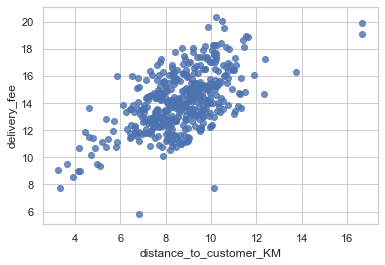

In [64]:
sns.regplot(x = 'distance_to_customer_KM', y = 'delivery_fee', fit_reg = False, 
            data = dirty_data_df[(dirty_data_df.loyalty == 0)])

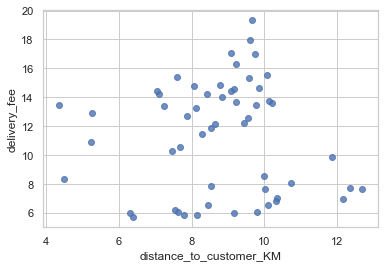

In [65]:
sns.regplot(x = 'distance_to_customer_KM', y = 'delivery_fee', fit_reg = False, 
            data = dirty_data_df[(dirty_data_df.loyalty == 1)])

There are few observations where the customers without loyalty paid a lot less than expected (in the first scatterplot) and many observations where customer with loyalty paid a lot more than expected (in the second scatterplot). We will have to fix these. Since we know that there are no mistakes in the delivery fee column, the mistake has to be in the loyalty column. <br><br>
We will now do some setup of the dataframe for fitting delivery fee.
* We first set a column for what the fee would have been without considering whether the customer had loyalty or not. This is the column that would be modelled. 
* Next, we need to have numerical columns indicating the time of the weekend and the meal type. 
* Further, we would separate the data into the three branches.
* Remove any unnecessary columns.

In [66]:
dirty_data_df['fee_wo_loyalty'] = 0.0

def set_fee_wo_loyalty(row):

    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # if customer has loyalty, double the delivery fee as that is supposed to be the calculated fee (ie. modellable)
    if (row.loyalty == 1):
        dirty_data_df.at[index, 'fee_wo_loyalty'] = row.delivery_fee * 2.0
    else:
        dirty_data_df.at[index, 'fee_wo_loyalty'] = row.delivery_fee
            
    return None

dirty_data_df.apply(set_fee_wo_loyalty, axis = 1);

In [67]:
# remove old columns of year, month and dat which might have wrong information
# also removing other columns
dirty_data_df.drop(['year', 'month', 'dat', 'hour',
       'minute', 'second', 'item_names', 'item_time_mismatch',
       'count_item_time_mismatch', 'eggs', 'pancakes', 'cereal', 'coffee',
       'steak', 'chicken', 'burger', 'salad', 'fries', 'shrimp', 'salmon',
       'f_chips', 'pasta', 'calc_price', 'customer_node', 'init_order_id',
       'branch_mismatch', 'branch_dist_mismatch'], axis = 1, inplace = True)

# add date, month and year columns
coltitle = dirty_data_df['date'].apply(lambda s: pd.Series({'year': s.split('-')[0].strip(),
                            'month': s.split('-')[1].strip(), 'dat':s.split('-')[2].strip()}))
dirty_data_df = pd.concat([dirty_data_df, coltitle], axis=1) 
dirty_data_df.head()

# add time and weekend indicator
dirty_data_df['time_num'] = 10
dirty_data_df['weekend'] = 10

def do_initial_setup_dirty(row):
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set up order type as a numerical value
    time_num = 0
    if row.order_type == "Dinner":
        time_num = 2
    elif row.order_type == "Lunch":
        time_num = 1
    dirty_data_df.at[index, 'time_num'] = time_num 
    
    # set up weekend/weekday
    weekend = 0
    day = datetime.date(int(row.year), int(row.month), int(row.dat)).weekday()
    if day > 4:
        weekend = 1
    dirty_data_df.at[index, 'weekend'] = weekend 
    
    return None

dirty_data_df.apply(do_initial_setup_dirty, axis = 1);
dirty_data_df.drop(['year', 'month', 'dat'], axis = 1, inplace = True)     # drop the redundant year, month and dates
dirty_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,no_corrections,fee_wo_loyalty,time_num,weekend
0,ORDX07870,2018-11-13,18:28:43,Dinner,BK,"[('Shrimp', 9), ('Fish&Chips', 8), ('Pasta', 2)]",821.0,-37.820999,144.943166,0,9.733,16.514295,1,16.514295,2,0
1,ORDK07313,2018-10-22,17:48:10,Dinner,BK,"[('Fish&Chips', 3), ('Salmon', 8), ('Shrimp', 8)]",865.0,-37.820072,144.982469,0,6.596,13.344356,0,13.344356,2,0
2,ORDJ02466,2018-01-27,08:50:42,Breakfast,TP,"[('Pancake', 6), ('Coffee', 8), ('Cereal', 9),...",526.5,-37.809265,144.931906,0,10.909,15.059879,1,15.059879,0,1
3,ORDA04640,2018-05-29,12:54:05,Lunch,BK,"[('Fries', 5), ('Chicken', 10), ('Salad', 6), ...",576.2,-37.804384,144.930085,0,10.722,16.971919,0,16.971919,1,0
4,ORDC06764,2018-04-16,11:22:49,Breakfast,NS,"[('Coffee', 3), ('Cereal', 9), ('Pancake', 6)]",357.0,-37.811042,144.966105,0,7.497,12.822199,1,12.822199,0,0


In [68]:
BK_dirty_df = dirty_data_df[dirty_data_df.branch_code == "BK"]
NS_dirty_df = dirty_data_df[dirty_data_df.branch_code == "NS"]
TP_dirty_df = dirty_data_df[dirty_data_df.branch_code == "TP"]

pd.set_option('mode.chained_assignment', None) 

Let us try fitting the delivery fees for the three branches using linear regression.

In [69]:
BK_LR_model = LinearRegression()

# fit and develop model
BK_LR_model.fit(BK_dirty_df[[x for x in BK_dirty_df.columns if (x == 'time_num' or 
                                                                x == 'weekend' or 
                                                                x == 'distance_to_customer_KM')]], 
                BK_dirty_df['fee_wo_loyalty'])

# get the fitted values
BK_fitted = BK_LR_model.predict(BK_dirty_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                  'branch_code', 'order_items', 'order_price', 
                                                  'customer_lat', 'customer_lon', 'loyalty', 
                                                  'delivery_fee', 'no_corrections', 'fee_wo_loyalty'], 
                                                 axis = 1)) 

BK_dirty_df['fitted_fee'] = BK_fitted
BK_dirty_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,no_corrections,fee_wo_loyalty,time_num,weekend,fitted_fee
0,ORDX07870,2018-11-13,18:28:43,Dinner,BK,"[('Shrimp', 9), ('Fish&Chips', 8), ('Pasta', 2)]",821.0,-37.820999,144.943166,0,9.733,16.514295,1,16.514295,2,0,17.999032
1,ORDK07313,2018-10-22,17:48:10,Dinner,BK,"[('Fish&Chips', 3), ('Salmon', 8), ('Shrimp', 8)]",865.0,-37.820072,144.982469,0,6.596,13.344356,0,13.344356,2,0,14.395960
3,ORDA04640,2018-05-29,12:54:05,Lunch,BK,"[('Fries', 5), ('Chicken', 10), ('Salad', 6), ...",576.2,-37.804384,144.930085,0,10.722,16.971919,0,16.971919,1,0,17.946271
5,ORDA10761,2018-12-31,20:00:00,Dinner,BK,"[('Pasta', 6), ('Fish&Chips', 10)]",515.0,-37.804833,144.958849,0,7.908,15.527767,0,15.527767,2,0,15.902887
6,ORDX05756,2018-06-01,12:54:05,Lunch,BK,"[('Fries', 7), ('Burger', 3), ('Chicken', 5), ...",806.8,-37.803059,144.950088,0,8.695,14.882052,1,14.882052,1,0,15.618115


We can see that there appears to be quite some difference in the fitted values and the observed values of the delivery fees and that most of the fitted values appear to be higher than the observed. This bias was introduced possibly as a result of the **high number of wrong data points seen in the second scatter plot** (as compared to the number in the first one). <br>
But, this should not be too much of a problem here as we are not too concerned about predicting any values - all we have to do is to see if the observed values that we see are either about double or about half of what is fitted.<br><br>
We will do the same for the other two branches as well. 

In [70]:
NS_LR_model = LinearRegression()
NS_LR_model.fit(NS_dirty_df[[x for x in NS_dirty_df.columns if (x == 'time_num' or 
                                                                x == 'weekend' or 
                                                                x == 'distance_to_customer_KM')]], 
                NS_dirty_df['fee_wo_loyalty'])                           # fit and train model

NS_fitted = NS_LR_model.predict(NS_dirty_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                  'branch_code', 'order_items', 'order_price', 
                                                  'customer_lat', 'customer_lon', 'loyalty', 
                                                  'delivery_fee', 'no_corrections', 'fee_wo_loyalty'], 
                                                 axis = 1))              # make predictions

NS_dirty_df['fitted_fee'] = NS_fitted

TP_LR_model = LinearRegression()
TP_LR_model.fit(TP_dirty_df[[x for x in TP_dirty_df.columns if (x == 'time_num' or 
                                                                x == 'weekend' or 
                                                                x == 'distance_to_customer_KM')]], 
                TP_dirty_df['fee_wo_loyalty'])                           # fit and train model

TP_fitted = TP_LR_model.predict(TP_dirty_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                  'branch_code', 'order_items', 'order_price', 
                                                  'customer_lat', 'customer_lon', 'loyalty', 
                                                  'delivery_fee', 'no_corrections', 'fee_wo_loyalty'], 
                                                 axis = 1))              # make predictions

TP_dirty_df['fitted_fee'] = TP_fitted

Copying the fitted values back to the original dataframe. 

In [71]:
dirty_data_df['fitted_fee'] = BK_dirty_df['fitted_fee']
dirty_data_df.loc[dirty_data_df['fitted_fee'].isnull() ,'fitted_fee'] = NS_dirty_df['fitted_fee']
dirty_data_df.loc[dirty_data_df['fitted_fee'].isnull() ,'fitted_fee'] = TP_dirty_df['fitted_fee']

pd.set_option('mode.chained_assignment', 'warn') 

def apply_loyalty(row):
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # halve the delivery fee for all customers with loyalty
    fee = dirty_data_df.loc[index, 'fitted_fee'] / 2.0
    dirty_data_df.at[index, 'fitted_fee'] = fee

    return None

dirty_data_df[dirty_data_df.loyalty == 1].apply(apply_loyalty, axis=1);

We now have in all the rows the fitted delivery fee corrected to the loyalty of the customers as well. Let us now try to find the ratio of the observed delivery fee to the fitted delivery fee. It is expected to be close to one for the correct cases and would be close to 0.5 or 2.0 for the wrong cases. Depending on whether the ratio is close to 0.5 or 2.0, we will make corrections accordingly in the loyalty column.

In [72]:
# get ratio of observed delivery fee to modelled/fitted delivery fee - should be close to 1 if all is right
dirty_data_df['ratio'] = dirty_data_df['delivery_fee']/dirty_data_df['fitted_fee']

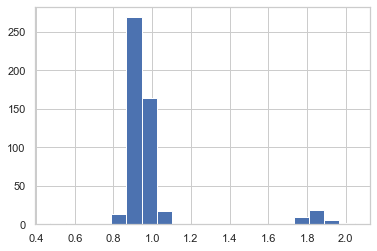

In [73]:
dirty_data_df['ratio'].hist(bins = 20)

As can be seen, most of the ratios are close to 1. There are a few that are close to 0.5 and some more that are close to 2. These observations have to be corrected. Judging from the histograms, choosing 0.7 and 1.4 as the thresholds.<br>
* For the observations where the ratio is greater than 1.4, we will change the loyalty to be 0.
* For the observations where the ratio is lesser than 0.7, we will change the loyalty to be 1.

In [74]:
dirty_data_df.loc[((dirty_data_df['ratio'] > 1.4) | (dirty_data_df['ratio'] < 0.7)), 'no_corrections'] = \
dirty_data_df.loc[((dirty_data_df['ratio'] > 1.4) | (dirty_data_df['ratio'] < 0.7)), 'no_corrections'].values + 1

# make the corrections - if significantly greater than 1 set customer to not have loyalty
#                      - if significantly  lesser than 1 set customer to have loyalty
dirty_data_df.loc[(dirty_data_df['ratio'] > 1.4), 'loyalty'] = 0
dirty_data_df.loc[(dirty_data_df['ratio'] < 0.7), 'loyalty'] = 1

dirty_data_df.loc[((dirty_data_df['ratio'] > 1.4) | (dirty_data_df['ratio'] < 0.7))]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,no_corrections,fee_wo_loyalty,time_num,weekend,fitted_fee,ratio
28,ORDJ07128,2018-08-05,15:05:54,Lunch,TP,"[('Salad', 2), ('Chicken', 1), ('Fries', 7)]",150.40,-37.809961,144.943493,0,9.843,14.661191,1,29.322381,1,1,7.952457,1.843605
39,ORDJ01655,2018-03-24,10:42:15,Breakfast,TP,"[('Cereal', 10), ('Pancake', 5), ('Eggs', 4)]",419.25,-37.819500,144.985203,0,9.232,13.683313,1,27.366625,0,1,7.323752,1.868347
56,ORDY10436,2018-06-28,13:54:55,Lunch,TP,"[('Burger', 1), ('Fries', 7)]",115.00,-37.807396,144.986931,0,10.129,13.738527,1,27.477054,1,0,7.181670,1.912999
63,ORDJ03298,2018-06-08,13:14:21,Lunch,TP,"[('Fries', 4), ('Chicken', 1), ('Burger', 1), ...",314.80,-37.804150,144.965873,0,9.564,12.560313,1,25.120626,1,0,6.986595,1.797773
73,ORDB09684,2018-10-07,17:17:44,Dinner,TP,"[('Pasta', 3), ('Fish&Chips', 5), ('Shrimp', 5)]",527.50,-37.808477,144.960709,0,8.779,14.817763,1,29.635527,2,1,8.002842,1.851563
75,ORDX08438,2018-02-28,09:51:32,Breakfast,BK,"[('Cereal', 10), ('Coffee', 4), ('Pancake', 2)...",508.50,-37.814507,144.999935,0,4.486,8.327591,1,16.655182,0,0,4.797537,1.735805
76,ORDC05079,2018-09-15,16:27:02,Dinner,NS,"[('Fish&Chips', 6), ('Shrimp', 5), ('Pasta', 6...",809.00,-37.807670,144.980369,0,7.601,15.431598,1,30.863195,2,1,8.857679,1.742172
80,ORDZ06899,2018-04-28,11:53:14,Breakfast,NS,"[('Eggs', 7), ('Cereal', 10), ('Coffee', 6), (...",530.25,-37.802366,144.962057,0,7.035,14.415060,1,28.830120,0,1,8.113045,1.776776
84,ORDX05828,2018-11-02,18:08:27,Dinner,BK,"[('Pasta', 6), ('Salmon', 6)]",411.00,-37.826139,144.951833,0,9.230,16.296844,1,32.593687,2,0,8.710650,1.870910
103,ORDY07783,2018-09-22,16:47:19,Dinner,TP,"[('Salmon', 4), ('Pasta', 8), ('Fish&Chips', 2...",940.00,-37.802439,144.948287,0,10.072,15.526991,1,31.053982,2,1,8.449271,1.837672


Plotting the scatterplots from earlier again to see what changes have been made. We can now see that there doesn't seem to be those observations which seem to have too low or too high delivery fee for their loyalty value.

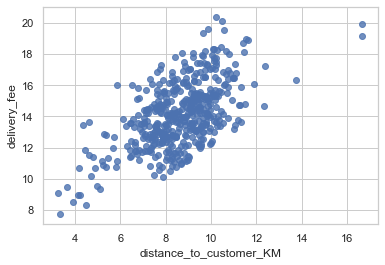

In [75]:
sns.regplot(x = 'distance_to_customer_KM', y = 'delivery_fee', fit_reg = False, 
            data = dirty_data_df[(dirty_data_df.loyalty == 0)])

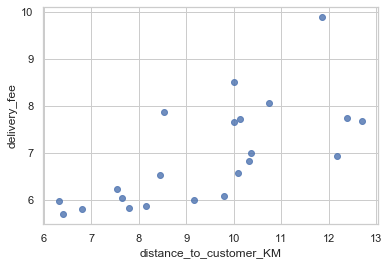

In [76]:
sns.regplot(x = 'distance_to_customer_KM', y = 'delivery_fee', fit_reg = False, 
            data = dirty_data_df[(dirty_data_df.loyalty == 1)])

That seems to have corrected all those mistakes with the loyalty column. We have also updated the `no_corrections` column to keep track of the changes. <br><br>
We know that there are no mistakes in the dirty files with respect to the delivery fee. This means that we have fixed all possible issues (hopefully). We can think about exporting the corrected file now.

## 2.4 Exporting the Corrected File
After all the corrections are done, we can now export the file. Few things to be done before that - we need to ensure that we have not made more than one correction on any given row. This would indicate that there was something wrong in the methods applied if we made more than one correction per row. 

In [77]:
dirty_data_df['no_corrections'].value_counts()

1    300
0    200
Name: no_corrections, dtype: int64

These counts indicate that there were **300 rows where one correction** was made and 200 rows where none were made. There are no rows where more than one correction was made. All looks good.<br>
**NOTE:** *The above step works on the assumption that the file has been executed sequentially and that each cell (at least all the cells which update the no_corrections column) has been executed only once.* <br><br>
The next step before exporting is making sure to **delete all the new columns** created for the cleaning process. These give no new information in most cases and are thus not required. <br>
The following are the columns to be deleted. 

In [78]:
dirty_data_df.columns[12:]

Index(['no_corrections', 'fee_wo_loyalty', 'time_num', 'weekend', 'fitted_fee',
       'ratio'],
      dtype='object')

Deleting the superflous columns and ensuring that everything looks to be in the required format.

In [79]:
dirty_data_df.drop(dirty_data_df.columns[12:], axis = 1, inplace = True)               # delete columns 
dirty_data_df = dirty_data_df.rename(columns={"loyalty":"customerHasloyalty?"})        # rename column

# rounding off these values as they are in the input file
dirty_data_df['customer_lat'] = round(dirty_data_df['customer_lat'], 7)
dirty_data_df['customer_lon'] = round(dirty_data_df['customer_lon'], 7)
dirty_data_df['delivery_fee'] = round(dirty_data_df['delivery_fee'], 7)
dirty_data_df['distance_to_customer_KM'] = round(dirty_data_df['distance_to_customer_KM'], 3)

dirty_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDX07870,2018-11-13,18:28:43,Dinner,BK,"[('Shrimp', 9), ('Fish&Chips', 8), ('Pasta', 2)]",821.0,-37.820999,144.943166,0,9.733,16.514295
1,ORDK07313,2018-10-22,17:48:10,Dinner,BK,"[('Fish&Chips', 3), ('Salmon', 8), ('Shrimp', 8)]",865.0,-37.820072,144.982469,0,6.596,13.344356
2,ORDJ02466,2018-01-27,08:50:42,Breakfast,TP,"[('Pancake', 6), ('Coffee', 8), ('Cereal', 9),...",526.5,-37.809265,144.931906,0,10.909,15.059879
3,ORDA04640,2018-05-29,12:54:05,Lunch,BK,"[('Fries', 5), ('Chicken', 10), ('Salad', 6), ...",576.2,-37.804384,144.930085,0,10.722,16.971919
4,ORDC06764,2018-04-16,11:22:49,Breakfast,NS,"[('Coffee', 3), ('Cereal', 9), ('Pancake', 6)]",357.0,-37.811042,144.966105,0,7.497,12.822199


And finally, exporting the dataframe to a csv file.

In [80]:
dirty_data_df.to_csv('Group149_dirty_data_solution.csv', index = False)  

# 3. Missing Data
## 3.1 Exploratory Data Analysis
We know that all the values in this file are all correct and can be trusted. There exists few missing values in this file and thus the dataframe. Describing all the variables in the dataframe can give an idea as to which columns have missing values. 

In [81]:
missing_data_df = pd.read_csv("Group149_missing_data.csv")

In [82]:
missing_data_df = missing_data_df.rename(columns={"customerHasloyalty?":"loyalty"})      # rename column for clarity
missing_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee
0,ORDZ01692,2018-05-18,12:33:48,Lunch,NS,"[('Chicken', 2), ('Burger', 1), ('Salad', 10),...",315.0,-37.803878,144.958409,0,7.530,NaN
1,ORDC08329,2018-04-08,11:12:40,Breakfast,NS,"[('Eggs', 10), ('Coffee', 10), ('Cereal', 9)]",484.0,-37.800610,144.970226,0,6.071,13.192944
2,ORDZ04035,2018-12-17,19:39:43,Dinner,NS,"[('Fish&Chips', 9), ('Salmon', 10), ('Shrimp',...",944.0,-37.805810,144.949019,0,8.601,14.622488
3,ORDY06321,2018-05-16,12:23:39,Lunch,NaN,"[('Steak', 8), ('Burger', 5), ('Fries', 5), ('...",759.4,-37.808763,144.971888,0,NaN,12.556318
4,ORDK10911,2018-01-16,08:30:25,Breakfast,BK,"[('Eggs', 5), ('Coffee', 4)]",140.0,-37.811942,144.945693,1,9.302,7.363481


In [83]:
missing_data_df.describe()

,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,450.000000,450.000000
mean,470.106100,-37.812686,144.965594,0.054000,8.666553,13.765634
std,255.206142,0.007659,0.020919,0.226244,1.567917,2.552669
min,36.000000,-37.827523,144.921636,0.000000,3.442000,5.381641
25%,286.562500,-37.819229,144.950306,0.000000,7.734750,12.527308
50%,415.750000,-37.813179,144.963786,0.000000,8.778500,13.810107
75%,614.975000,-37.806327,144.980128,0.000000,9.717000,15.297974
max,1251.500000,-37.793077,145.015510,1.000000,12.364000,19.586634


In [84]:
missing_data_df.describe(include=['O'])

,order_id,date,time,order_type,branch_code,order_items
count,500,500,500,500,400,500
unique,500,262,72,3,3,496
top,ORDY01728,2018-07-15,11:53:14,Breakfast,NS,"[('Cereal', 6), ('Eggs', 1)]"
freq,1,8,16,188,135,2


Clearly, all values are present for all the columns except `distance_to_customer_KM`, `delivery_fee` and `branch_code`. There are 50 values missing in `distance_to_customer_KM` and `delivery_fee` while there are 100 values missing in `branch_code`. We can also assume that all the information available is correct.

As a first step, we split the date into year, month and date.

In [85]:
# make date, month and year columns
coltitle = missing_data_df['date'].apply(lambda s: pd.Series({'year': s.split('-')[0].strip(),
                            'month': s.split('-')[1].strip(), 'dat':s.split('-')[2].strip()}))
missing_data_df = pd.concat([missing_data_df, coltitle], axis=1) 
missing_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,year,month,dat
0,ORDZ01692,2018-05-18,12:33:48,Lunch,NS,"[('Chicken', 2), ('Burger', 1), ('Salad', 10),...",315.0,-37.803878,144.958409,0,7.530,NaN,2018,05,18
1,ORDC08329,2018-04-08,11:12:40,Breakfast,NS,"[('Eggs', 10), ('Coffee', 10), ('Cereal', 9)]",484.0,-37.800610,144.970226,0,6.071,13.192944,2018,04,08
2,ORDZ04035,2018-12-17,19:39:43,Dinner,NS,"[('Fish&Chips', 9), ('Salmon', 10), ('Shrimp',...",944.0,-37.805810,144.949019,0,8.601,14.622488,2018,12,17
3,ORDY06321,2018-05-16,12:23:39,Lunch,NaN,"[('Steak', 8), ('Burger', 5), ('Fries', 5), ('...",759.4,-37.808763,144.971888,0,NaN,12.556318,2018,05,16
4,ORDK10911,2018-01-16,08:30:25,Breakfast,BK,"[('Eggs', 5), ('Coffee', 4)]",140.0,-37.811942,144.945693,1,9.302,7.363481,2018,01,16


The three new columns are in place and appropriately populated. <br><br>
Next, we add **customer node**, **time of order** (as a numerical value) and **weekend** (as a numerical value). This is done using the node information provided for customer node, `datetime` package for weekend and just using the order type for the time of day column. 

In [86]:
missing_data_df['customer_node'] = 0
missing_data_df['time_num'] = 10
missing_data_df['weekend'] = 10

def do_initial_setup_missing(row):
    index = missing_data_df[missing_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set up the customer node
    customer_node = nodes_df[(nodes_df.lat == row['customer_lat']) 
                   & (nodes_df.lon == row['customer_lon'])].node.iloc[0]
    missing_data_df.at[index, 'customer_node'] = customer_node 
    
    # set up order type as a numerical value
    time_num = 0
    if row.order_type == "Dinner":
        time_num = 2
    elif row.order_type == "Lunch":
        time_num = 1
    missing_data_df.at[index, 'time_num'] = time_num 
    
    # set up weekend/weekday
    weekend = 0
    day = datetime.date(int(row.year), int(row.month), int(row.dat)).weekday()
    if day > 4:
        weekend = 1
    missing_data_df.at[index, 'weekend'] = weekend 

missing_data_df.apply(do_initial_setup_missing, axis = 1);
missing_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,year,month,dat,customer_node,time_num,weekend
0,ORDZ01692,2018-05-18,12:33:48,Lunch,NS,"[('Chicken', 2), ('Burger', 1), ('Salad', 10),...",315.0,-37.803878,144.958409,0,7.530,NaN,2018,05,18,777829888,1,0
1,ORDC08329,2018-04-08,11:12:40,Breakfast,NS,"[('Eggs', 10), ('Coffee', 10), ('Cereal', 9)]",484.0,-37.800610,144.970226,0,6.071,13.192944,2018,04,08,2841675038,0,1
2,ORDZ04035,2018-12-17,19:39:43,Dinner,NS,"[('Fish&Chips', 9), ('Salmon', 10), ('Shrimp',...",944.0,-37.805810,144.949019,0,8.601,14.622488,2018,12,17,3215191995,2,0
3,ORDY06321,2018-05-16,12:23:39,Lunch,NaN,"[('Steak', 8), ('Burger', 5), ('Fries', 5), ('...",759.4,-37.808763,144.971888,0,NaN,12.556318,2018,05,16,2948774581,1,0
4,ORDK10911,2018-01-16,08:30:25,Breakfast,BK,"[('Eggs', 5), ('Coffee', 4)]",140.0,-37.811942,144.945693,1,9.302,7.363481,2018,01,16,2133726646,0,0


These three new columns are appropriately populated as well.

Now, let us plot few boxplots and see what relationships we can find.

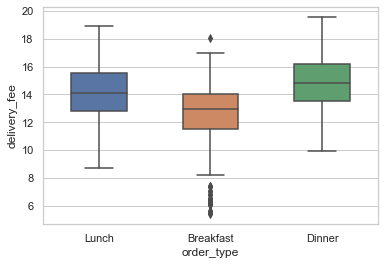

In [87]:
sns.boxplot(y = 'delivery_fee', x = 'order_type', data = missing_data_df, width = 0.50)

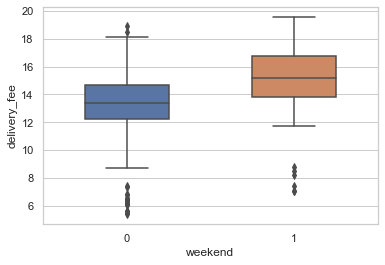

In [88]:
sns.boxplot(y = 'delivery_fee', x = 'weekend', data = missing_data_df, width = 0.50)

From these, we see that delivery fees are higher on weekends and that the fee increases from breakfast to dinner. We also know that the fees are dependent on the distance. Let us try a scatterplot of distance vs delivery fee.

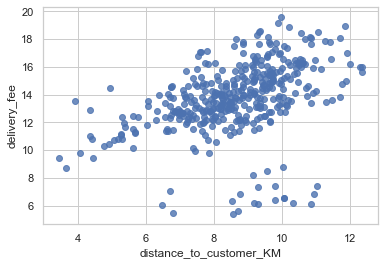

In [89]:
sns.regplot(x = 'distance_to_customer_KM', y = 'delivery_fee', data = missing_data_df, fit_reg = False)

There seems to be some positive association here, but the data is very cloudy and we can't really make anything much out of it. 

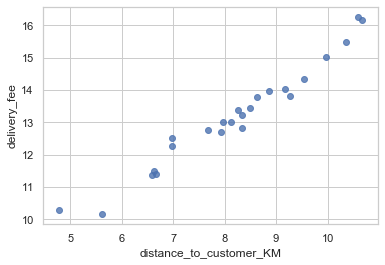

In [90]:
sns.regplot(x = 'distance_to_customer_KM', y = 'delivery_fee', fit_reg = False, 
            data = missing_data_df[(missing_data_df.time_num == 0) & (missing_data_df.weekend == 0) & 
                                   (missing_data_df.branch_code == "BK") & (missing_data_df.loyalty == 0)])

With these restrictions applied, now the data seems much more linear and modellable. Let's move onto actual imputation now. 

## 3.2 Imputing Missing Data
### 3.2.1 Imputing Branch Codes

In [91]:
len(missing_data_df[(missing_data_df.branch_code.isnull())])

100

There are 100 rows where we do not have branch codes. We can easily impute these by using the same logic we used to correct the wrong values in the dirty data. 

In [92]:
def set_branch_code(row):
    index = missing_data_df[missing_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set branch code as per the order ID pattern
    if ((row.init_order_id == "ORDA") or (row.init_order_id == "ORDK") or (row.init_order_id == "ORDX")):
        missing_data_df.at[index, 'branch_code'] = "BK"
    elif ((row.init_order_id == "ORDC") or (row.init_order_id == "ORDI") or (row.init_order_id == "ORDZ")):
        missing_data_df.at[index, 'branch_code'] = "NS"
    elif ((row.init_order_id == "ORDB") or (row.init_order_id == "ORDJ") or (row.init_order_id == "ORDY")):
        missing_data_df.at[index, 'branch_code'] = "TP"

    return None

missing_data_df['init_order_id'] = missing_data_df['order_id'].str[:4]
missing_data_df[missing_data_df.branch_code.isnull()].apply(set_branch_code, axis = 1);
len(missing_data_df[(missing_data_df.branch_code.isnull())])

0

There are now no more missing branch codes. Now we have 50 missing distances and 50 missing delivery fees.

### 3.2.2 Imputing Distances

In [93]:
len(missing_data_df[missing_data_df.distance_to_customer_KM.isnull()])

50

We have 50 rows with distance information missing. The distances are to be calculated from the customer nodes to the branches. Since we now have all the branch code, getting the required distances should be easy. We can use same methodology used for the dirty data itself.

In [94]:
def set_distance(row):

    index = missing_data_df[missing_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set distance according to the branch
    if (row.branch_code.upper() == "NS"):
        dist_to_NS = nx.shortest_path_length(G, row.customer_node, NS_node.iloc[0], 'distance(m)')
        missing_data_df.at[index, 'distance_to_customer_KM'] = round(dist_to_NS/1000, 3)
    elif (row.branch_code.upper() == "TP"):
        dist_to_TP = nx.shortest_path_length(G, row.customer_node, TP_node.iloc[0], 'distance(m)')
        missing_data_df.at[index, 'distance_to_customer_KM'] = round(dist_to_TP/1000, 3)
    elif (row.branch_code.upper() == "BK"):
        dist_to_BK = nx.shortest_path_length(G, row.customer_node, BK_node.iloc[0], 'distance(m)')
        missing_data_df.at[index, 'distance_to_customer_KM'] = round(dist_to_BK/1000, 3)
            
    return None

missing_data_df[missing_data_df.distance_to_customer_KM.isnull()].apply(set_distance, axis = 1);
len(missing_data_df[missing_data_df.distance_to_customer_KM.isnull()])

0

### 3.2.3 Imputing Delivery Fees
With the distances also imputed, we are now left with 50 rows of delivery fees to impute. We know that the delivery fee is dependent on the meal type, the day of the week, distance from branch and whether the customer has loyalty or not. We also know that each branch calculates the delivery fee differently from each other. <br>
We have to model the information that we have to find the delivery fees where it is not available. We will have to have three models for the three branches.<br>
Further, since we also have the information about the delivery fees from the (now cleaned) dirty data file, we can use that also to model the delivery fees. More training data ensures a more accurate model.

In [95]:
missing_data_df['original'] = True      # to be able to remove the data added from dirty data 
missing_data_df.drop(['year', 'month', 'dat', 'customer_node', 'init_order_id'], axis = 1, inplace = True)

In [96]:
dirty_data_df = dirty_data_df.rename(columns={"customerHasloyalty?":"loyalty"})

# add date, month and year columns
coltitle = dirty_data_df['date'].apply(lambda s: pd.Series({'year': s.split('-')[0].strip(),
                            'month': s.split('-')[1].strip(), 'dat':s.split('-')[2].strip()}))
dirty_data_df = pd.concat([dirty_data_df, coltitle], axis=1) 
dirty_data_df.head()

# add time and weekend indicator
dirty_data_df['time_num'] = 10
dirty_data_df['weekend'] = 10
dirty_data_df['original'] = False

def do_initial_setup_dirty(row):
    index = dirty_data_df[dirty_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set up order type as a numerical value
    time_num = 0
    if row.order_type == "Dinner":
        time_num = 2
    elif row.order_type == "Lunch":
        time_num = 1
    dirty_data_df.at[index, 'time_num'] = time_num 
    
    # set up weekend/weekday
    weekend = 0
    day = datetime.date(int(row.year), int(row.month), int(row.dat)).weekday()
    if day > 4:
        weekend = 1
    dirty_data_df.at[index, 'weekend'] = weekend 
    
    return None

dirty_data_df.apply(do_initial_setup_dirty, axis = 1);
dirty_data_df.drop(['year', 'month', 'dat'], axis = 1, inplace = True)
dirty_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,time_num,weekend,original
0,ORDX07870,2018-11-13,18:28:43,Dinner,BK,"[('Shrimp', 9), ('Fish&Chips', 8), ('Pasta', 2)]",821.0,-37.820999,144.943166,0,9.733,16.514295,2,0,False
1,ORDK07313,2018-10-22,17:48:10,Dinner,BK,"[('Fish&Chips', 3), ('Salmon', 8), ('Shrimp', 8)]",865.0,-37.820072,144.982469,0,6.596,13.344356,2,0,False
2,ORDJ02466,2018-01-27,08:50:42,Breakfast,TP,"[('Pancake', 6), ('Coffee', 8), ('Cereal', 9),...",526.5,-37.809265,144.931906,0,10.909,15.059879,0,1,False
3,ORDA04640,2018-05-29,12:54:05,Lunch,BK,"[('Fries', 5), ('Chicken', 10), ('Salad', 6), ...",576.2,-37.804384,144.930085,0,10.722,16.971919,1,0,False
4,ORDC06764,2018-04-16,11:22:49,Breakfast,NS,"[('Coffee', 3), ('Cereal', 9), ('Pancake', 6)]",357.0,-37.811042,144.966105,0,7.497,12.822199,0,0,False


Now, both missing data and dirty data have all the required columns and are also in the same format. Let us join them together. <br>
Note that all rows from the original missing data table will have original flag set to True while the ones from dirty data will have it set to false. This will enable us to delete the data from the dirty data file after use. 

In [97]:
missing_data_df = pd.concat([missing_data_df, dirty_data_df], ignore_index = True) 
len(missing_data_df)

1000

We now have the dataframe which contains 1000 rows of information in which we have 50 rows with data missing in the delivery fee column. <br> 
Let us also make a row which contains the delivery fee before the loyalty condition has been applied. It would not make sense to model the relationship of the loyalty card as **we already know deterministically** what that relationship is. 

In [98]:
missing_data_df['fee_wo_loyalty'] = 0.0

def set_fee_wo_loyalty(row):

    index = missing_data_df[missing_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # if customer has loyalty, double the fee - this is what is calculated according to 
    if (row.loyalty == 1):
        missing_data_df.at[index, 'fee_wo_loyalty'] = row.delivery_fee * 2.0
    else:
        missing_data_df.at[index, 'fee_wo_loyalty'] = row.delivery_fee
            
    return None

missing_data_df[missing_data_df.delivery_fee.notnull()].apply(set_fee_wo_loyalty, axis = 1);
missing_data_df.loc[missing_data_df.delivery_fee.isnull(), 'fee_wo_loyalty'] = np.nan

len(missing_data_df[missing_data_df.fee_wo_loyalty.isnull()])

50

We now have 50 rows without the `fee_wo_loyalty` column values. This is the column that we will attempt to model. We will in fact create 3 different models - one for each branch as they calculate the fee differently. Let us seperate the information into 3 now. 

In [99]:
pd.set_option('mode.chained_assignment', None) 

BK_impute_df = missing_data_df[missing_data_df['branch_code'] == 'BK']
NS_impute_df = missing_data_df[missing_data_df['branch_code'] == 'NS']
TP_impute_df = missing_data_df[missing_data_df['branch_code'] == 'TP']

print(len(BK_impute_df), len(NS_impute_df), len(TP_impute_df))

335 336 329


The lengths of the 3 dataframes add up to 1000. All looks good. 

In [100]:
BK_fitting_df = BK_impute_df.dropna(subset = ['fee_wo_loyalty'], axis = 0)
NS_fitting_df = NS_impute_df.dropna(subset = ['fee_wo_loyalty'], axis = 0)
TP_fitting_df = TP_impute_df.dropna(subset = ['fee_wo_loyalty'], axis = 0)

print(len(BK_fitting_df), len(NS_fitting_df), len(TP_fitting_df))

323 319 308


These counts add up to 950. Again, all looks good.

In [101]:
BK_LR_model_missing = LinearRegression()

BK_LR_model_missing.fit(BK_fitting_df[[x for x in BK_fitting_df.columns if (x == 'time_num' or 
                                                                            x == 'weekend' or 
                                                                            x == 'distance_to_customer_KM')]], 
                        BK_fitting_df['fee_wo_loyalty'])                  # fit and train model

# get fitted values - on the training set itself - just to check validity
BK_fitted = BK_LR_model_missing.predict(BK_fitting_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                            'branch_code', 'order_items', 'order_price', 
                                                            'customer_lat', 'customer_lon', 'customer_lon', 
                                                            'loyalty', 'delivery_fee', 'original', 'fee_wo_loyalty'], 
                                                           axis = 1))     
BK_fitting_df['fitted_fee'] = BK_fitted

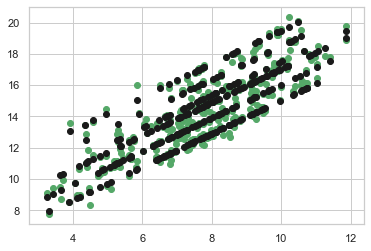

In [102]:
# making new variables to plot on the same graph
X = BK_fitting_df['distance_to_customer_KM'].values[:, np.newaxis]
y = BK_fitting_df['fee_wo_loyalty'].values
z = BK_fitting_df['fitted_fee'].values

plt.scatter(X, y, color = 'g')
plt.scatter(X, z, color = 'k')

plt.show()

Above, we have first fit a model for the branch BK considering distance, day of week and time of meal as the independent variables and have plotted the fitted values along with the observed ones. The black points seem to be good predictions for the delivery fees. 

In [103]:
# make actual predictions
BK_predictions = BK_LR_model_missing.predict(BK_impute_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                                'branch_code', 'order_items', 'order_price', 
                                                                'customer_lat', 'customer_lon', 'customer_lon', 
                                                                'loyalty', 'delivery_fee', 'original', 
                                                                'fee_wo_loyalty'],
                                                               axis = 1)) 
BK_impute_df['fee_hats'] = BK_predictions

Here, we have also made actual predictions where data was missing earlier. <br>
Let us do the same for both the other branches as well. This time, not going to check the appropriateness as with the scatter plot.

In [104]:
# Making predictions for NS branch
NS_LR_model_missing = LinearRegression()
NS_LR_model_missing.fit(NS_fitting_df[[x for x in NS_fitting_df.columns if (x == 'time_num' or 
                                                                            x == 'weekend' or 
                                                                            x == 'distance_to_customer_KM')]], 
                        NS_fitting_df['fee_wo_loyalty'])             # train model

NS_predictions = NS_LR_model_missing.predict(NS_impute_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                                'branch_code', 'order_items', 'order_price', 
                                                                'customer_lat', 'customer_lon', 'customer_lon', 
                                                                'loyalty', 'delivery_fee', 'original', 
                                                                'fee_wo_loyalty'],
                                                               axis = 1)) 
NS_impute_df['fee_hats'] = NS_predictions

# Making predictions for TP branch
TP_LR_model_missing = LinearRegression()
TP_LR_model_missing.fit(TP_fitting_df[[x for x in TP_fitting_df.columns if (x == 'time_num' or 
                                                                            x == 'weekend' or 
                                                                            x == 'distance_to_customer_KM')]], 
                        TP_fitting_df['fee_wo_loyalty'])             # train model

TP_predictions = TP_LR_model_missing.predict(TP_impute_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                                'branch_code', 'order_items', 'order_price', 
                                                                'customer_lat', 'customer_lon', 'customer_lon', 
                                                                'loyalty', 'delivery_fee', 'original', 
                                                                'fee_wo_loyalty'],
                                                               axis = 1)) 
TP_impute_df['fee_hats'] = TP_predictions

Above, we have made the predictions of the delivery fees (all for no loyalty scenario) for all branches. Now, let us bring them all together into the original table and apply the loyalty rule where necessary.

In [105]:
missing_data_df['fee_hats'] = BK_impute_df['fee_hats']
missing_data_df.loc[missing_data_df['fee_hats'].isnull() ,'fee_hats'] = NS_impute_df['fee_hats']
missing_data_df.loc[missing_data_df['fee_hats'].isnull() ,'fee_hats'] = TP_impute_df['fee_hats']

pd.set_option('mode.chained_assignment', 'warn') 

def apply_loyalty_missing(row):
    index = missing_data_df[missing_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # apply rule of loyalty - halve the delivery fee if customer has loyalty
    fee = missing_data_df.loc[index, 'fee_hats'] / 2.0
    missing_data_df.at[index, 'fee_hats'] = fee

    return None

missing_data_df[missing_data_df.loyalty == 1].apply(apply_loyalty_missing, axis = 1);

Now that we have all the data, plotting once again. We can observe different slopes in the predicted values - this is because of the different models having different co-efficients for the distance. 

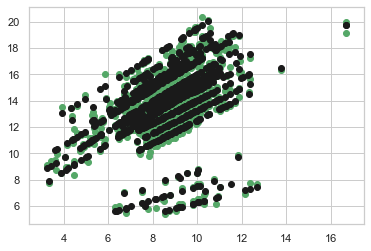

In [106]:
X = missing_data_df['distance_to_customer_KM'].values[:, np.newaxis]
y = missing_data_df['delivery_fee'].values
z = missing_data_df['fee_hats'].values

plt.scatter(X, y, color = 'g')
plt.scatter(X, z, color = 'k')

plt.show()

Now we have all the missing data as well. All we need to do now is to copy over the `fee_hats` to the `delivery_fee` column where they are missing.

In [107]:
missing_data_df.loc[missing_data_df.delivery_fee.isnull(), 'delivery_fee'] = missing_data_df['fee_hats']
len(missing_data_df[missing_data_df.delivery_fee == missing_data_df.fee_hats])

50

We can see that there is 50 rows where the delivery fee is exactly equal to the predicted fee - these are the 50 rows that we imputed. <br>
Double checking that there are **no nulls now in our dataframe** - there are 50 missing values in `fee_wo_loyalty`, but that does not matter as we are not going to output that.

In [108]:
missing_data_df.isna().sum()

order_id                    0
date                        0
time                        0
order_type                  0
branch_code                 0
order_items                 0
order_price                 0
customer_lat                0
customer_lon                0
loyalty                     0
distance_to_customer_KM     0
delivery_fee                0
time_num                    0
weekend                     0
original                    0
fee_wo_loyalty             50
fee_hats                    0
dtype: int64

## 3.3 Exporting the Imputed File
After all the imputations are done, we can now export the file. Few things to be done before that - we need to delete the extra rows from the dirty data file, delete extra columns created for help with analysis and imputation, and change back the name of the loyalty column.

In [109]:
# drop rows from other table
missing_data_df = missing_data_df.drop(missing_data_df[missing_data_df.original == False].index)

missing_data_df.drop(missing_data_df.columns[12:], axis = 1, inplace = True)             # drop unnecessary columns
missing_data_df = missing_data_df.rename(columns={"loyalty":"customerHasloyalty?"})      # rename column

# rounding off these values as they are in the input file
missing_data_df['customer_lat'] = round(missing_data_df['customer_lat'], 7)
missing_data_df['customer_lon'] = round(missing_data_df['customer_lon'], 7)
missing_data_df['delivery_fee'] = round(missing_data_df['delivery_fee'], 7)
missing_data_df['distance_to_customer_KM'] = round(missing_data_df['distance_to_customer_KM'], 3)

missing_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDZ01692,2018-05-18,12:33:48,Lunch,NS,"[('Chicken', 2), ('Burger', 1), ('Salad', 10),...",315.0,-37.803878,144.958409,0,7.530,13.011098
1,ORDC08329,2018-04-08,11:12:40,Breakfast,NS,"[('Eggs', 10), ('Coffee', 10), ('Cereal', 9)]",484.0,-37.800610,144.970226,0,6.071,13.192944
2,ORDZ04035,2018-12-17,19:39:43,Dinner,NS,"[('Fish&Chips', 9), ('Salmon', 10), ('Shrimp',...",944.0,-37.805810,144.949019,0,8.601,14.622488
3,ORDY06321,2018-05-16,12:23:39,Lunch,TP,"[('Steak', 8), ('Burger', 5), ('Fries', 5), ('...",759.4,-37.808763,144.971888,0,9.175,12.556318
4,ORDK10911,2018-01-16,08:30:25,Breakfast,BK,"[('Eggs', 5), ('Coffee', 4)]",140.0,-37.811942,144.945693,1,9.302,7.363481


Doing some checks to see if there are any nulls and to check the size of the dataframe.

In [110]:
missing_data_df.isna().sum()

order_id                   0
date                       0
time                       0
order_type                 0
branch_code                0
order_items                0
order_price                0
customer_lat               0
customer_lon               0
customerHasloyalty?        0
distance_to_customer_KM    0
delivery_fee               0
dtype: int64

In [111]:
len(missing_data_df)

500

And now, finally, we can export the imputed file.

In [112]:
missing_data_df.to_csv('Group149_missing_data_solution.csv', index = False)  

# 4. Outliers
## 4.1 Exploratory Data Analysis
We know already that all the information in all columns except the delivery fee is correct in the `Group149_outlier_data.csv` file and thus is the `outliers_data_df` dataframe. We also know that there are certain outliers in that column. Further, delivery fee is dependent on day of the week, distance from branch and meal type.<br>
Let us now make a boxplot of the delivery fee and describe it to see if we can spot any outliers. 

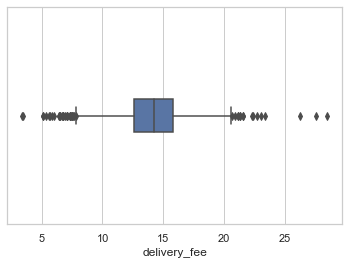

In [113]:
sns.boxplot(outliers_data_df['delivery_fee'], width = 0.15)

In [114]:
outliers_data_df['delivery_fee'].describe()

count    500.000000
mean      14.057744
std        3.321552
min        3.409988
25%       12.601924
50%       14.204260
75%       15.799886
max       28.457083
Name: delivery_fee, dtype: float64

There seems to be many outliers as per the boxplot. We can see that the minima is around AUD 3.50 and the maxima around AUD 28.50. <br>
But, we need to be careful about removing outliers without other analysis as there are other factors such as day of the week, time of the meal and distance from branch which affects the delivery fee. Let us make **boxplots with respect to weekend as well as with meal time** before moving ahead. <br>
Before that creating the required columns and populating values appropriately in them.

In [115]:
# add columns for date, month and year
coltitle = outliers_data_df['date'].apply(lambda s: pd.Series({'year': s.split('-')[0].strip(),
                            'month': s.split('-')[1].strip(), 'dat':s.split('-')[2].strip()}))
outliers_data_df = pd.concat([outliers_data_df, coltitle], axis=1) 
outliers_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,year,month,dat
0,ORDX10841,2018-09-27,16:57:27,Dinner,BK,"[('Shrimp', 8), ('Salmon', 4), ('Fish&Chips', ...",998.50,-37.803562,144.945311,0,9.148,8.253948,2018,09,27
1,ORDZ06960,2018-06-15,13:24:30,Lunch,NS,"[('Steak', 9), ('Chicken', 10)]",725.00,-37.818733,145.015963,0,11.866,17.386152,2018,06,15
2,ORDK09812,2018-01-28,08:50:42,Breakfast,BK,"[('Eggs', 8), ('Pancake', 9), ('Cereal', 10), ...",679.25,-37.811478,144.938166,0,10.034,17.598874,2018,01,28
3,ORDJ11099,2018-11-11,18:28:43,Dinner,TP,"[('Salmon', 5), ('Fish&Chips', 1), ('Shrimp', ...",567.00,-37.818288,144.946777,0,9.283,15.149030,2018,11,11
4,ORDA10794,2018-08-06,15:05:54,Lunch,BK,"[('Chicken', 10), ('Steak', 8), ('Burger', 7),...",1000.20,-37.811975,144.965722,0,7.447,13.247658,2018,08,06


In [116]:
outliers_data_df['customer_node'] = 0
outliers_data_df['time_num'] = 10
outliers_data_df['weekend'] = 10

def do_initial_setup(row):
    index = outliers_data_df[outliers_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set up the customer node
    customer_node = nodes_df[(nodes_df.lat == row['customer_lat']) 
                   & (nodes_df.lon == row['customer_lon'])].node.iloc[0]
    outliers_data_df.at[index, 'customer_node'] = customer_node 
    
    # set up order type as a numerical value
    time_num = 0
    if row.order_type == "Dinner":
        time_num = 2
    elif row.order_type == "Lunch":
        time_num = 1
    outliers_data_df.at[index, 'time_num'] = time_num 
    
    # set up weekend/weekday
    weekend = 0
    day = datetime.date(int(row.year), int(row.month), int(row.dat)).weekday()
    if day > 4:
        weekend = 1
    outliers_data_df.at[index, 'weekend'] = weekend 

outliers_data_df.apply(do_initial_setup, axis = 1);
outliers_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,year,month,dat,customer_node,time_num,weekend
0,ORDX10841,2018-09-27,16:57:27,Dinner,BK,"[('Shrimp', 8), ('Salmon', 4), ('Fish&Chips', ...",998.50,-37.803562,144.945311,0,9.148,8.253948,2018,09,27,387152941,2,0
1,ORDZ06960,2018-06-15,13:24:30,Lunch,NS,"[('Steak', 9), ('Chicken', 10)]",725.00,-37.818733,145.015963,0,11.866,17.386152,2018,06,15,370469699,1,0
2,ORDK09812,2018-01-28,08:50:42,Breakfast,BK,"[('Eggs', 8), ('Pancake', 9), ('Cereal', 10), ...",679.25,-37.811478,144.938166,0,10.034,17.598874,2018,01,28,560997645,0,1
3,ORDJ11099,2018-11-11,18:28:43,Dinner,TP,"[('Salmon', 5), ('Fish&Chips', 1), ('Shrimp', ...",567.00,-37.818288,144.946777,0,9.283,15.149030,2018,11,11,3276387458,2,1
4,ORDA10794,2018-08-06,15:05:54,Lunch,BK,"[('Chicken', 10), ('Steak', 8), ('Burger', 7),...",1000.20,-37.811975,144.965722,0,7.447,13.247658,2018,08,06,600782163,1,0


In [117]:
outliers_data_df[['customer_node', 'time_num', 'weekend']].describe()

,customer_node,time_num,weekend
count,5.000000e+02,500.000000,500.000000
mean,2.206852e+09,1.032000,0.306000
std,2.031906e+09,0.807639,0.461291
min,2.668006e+07,0.000000,0.000000
25%,5.768288e+08,0.000000,0.000000
50%,1.462399e+09,1.000000,0.000000
75%,3.739664e+09,2.000000,1.000000
max,6.282174e+09,2.000000,1.000000


The set-up seems to be appropriate. Now, onto plotting the box plots.

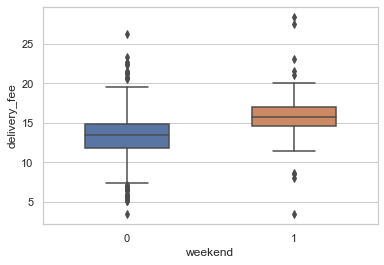

In [118]:
sns.boxplot(y = 'delivery_fee', x = 'weekend', data = outliers_data_df, width = 0.50)

On weekends, the delivery fee seems to be higher. Also, some outliers on weekends might not be on weekdays. 

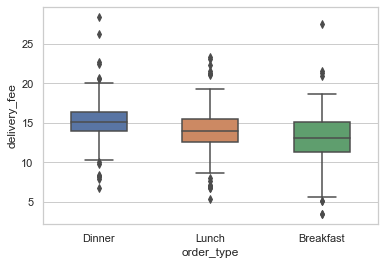

In [119]:
sns.boxplot(y = 'delivery_fee', x = 'order_type', data = outliers_data_df, width = 0.50)

Similarly, delivery fee seems to be increasing from breakfast to dinner. We still have issues of mismatching outliers. <br>The best thing to do might be to **find outliers of the residuals** after applying the same models that we applied to the missing data.  

## 4.2 Finding and Deleting Outliers
### 4.2.1 Applying Models to Predict Delivery Fees
As we saw in missing data as well, it might be best to develop the model using more amounts of data. Particularly in the case of outlier detection as well, having more data that are not outliers will help a lot more. For this, we will use data from dirty data and missing data as we are now convinced that those give good inputs. <br><br>
Let us see what columns we have in each of our tables right now.

In [120]:
dirty_data_df.columns

Index(['order_id', 'date', 'time', 'order_type', 'branch_code', 'order_items',
       'order_price', 'customer_lat', 'customer_lon', 'loyalty',
       'distance_to_customer_KM', 'delivery_fee', 'time_num', 'weekend',
       'original'],
      dtype='object')

In [121]:
missing_data_df.columns

Index(['order_id', 'date', 'time', 'order_type', 'branch_code', 'order_items',
       'order_price', 'customer_lat', 'customer_lon', 'customerHasloyalty?',
       'distance_to_customer_KM', 'delivery_fee'],
      dtype='object')

In [122]:
outliers_data_df.columns

Index(['order_id', 'date', 'time', 'order_type', 'branch_code', 'order_items',
       'order_price', 'customer_lat', 'customer_lon', 'customerHasloyalty?',
       'distance_to_customer_KM', 'delivery_fee', 'year', 'month', 'dat',
       'customer_node', 'time_num', 'weekend'],
      dtype='object')

It probably might be easier to bring everything down to the original format then work from there. So, removing the new columns of all the dataframes. Changing the `customerHasloyalty?` column's name to `loyalty` everywhere as well. 

In [123]:
# drop extra columns, set original flag to false
dirty_data_df.drop(dirty_data_df.columns[12:], axis = 1, inplace = True)
dirty_data_df['original'] = False

# rename column for clarity and set original flag to false
missing_data_df = missing_data_df.rename(columns={"customerHasloyalty?":"loyalty"})
missing_data_df['original'] = False

# drop extra columns, rename column for clarity and set original flag to true
outliers_data_df.drop(outliers_data_df.columns[12:], axis = 1, inplace = True)
outliers_data_df = outliers_data_df.rename(columns={"customerHasloyalty?":"loyalty"})
outliers_data_df['original'] = True

Now, all the dataframes would be in the same format and mergeable. Also, there is a original flag that is set to true for all the observations that are actually from the outliers dataframe.<br>
Let us now merge the data.

In [124]:
# merge together all three dataframes
outliers_data_df = pd.concat([outliers_data_df, dirty_data_df], ignore_index = True) 
outliers_data_df = pd.concat([outliers_data_df, missing_data_df], ignore_index = True) 

len(outliers_data_df)

1500

In [125]:
len(outliers_data_df[outliers_data_df.original])

500

Good - now we have a dataframe with 1500 observations where 500 of them have the original flag set to true. <br>
Now, let us do some setup to get the days of the week and the time of meal in numeric fields and also to set the delivery fee without loyalty. This would be our dependent variable for modelling.

In [126]:
# add columns for year, month and date
coltitle = outliers_data_df['date'].apply(lambda s: pd.Series({'year': s.split('-')[0].strip(),
                            'month': s.split('-')[1].strip(), 'dat':s.split('-')[2].strip()}))
outliers_data_df = pd.concat([outliers_data_df, coltitle], axis=1) 

outliers_data_df['time_num'] = 10
outliers_data_df['weekend'] = 10
outliers_data_df['fee_wo_loyalty'] = 0.0

def do_initial_setup_outliers(row):
    index = outliers_data_df[outliers_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # set up order type as a numerical value
    time_num = 0
    if row.order_type == "Dinner":
        time_num = 2
    elif row.order_type == "Lunch":
        time_num = 1
    outliers_data_df.at[index, 'time_num'] = time_num 
    
    # set up weekend/weekday
    weekend = 0
    day = datetime.date(int(row.year), int(row.month), int(row.dat)).weekday()
    if day > 4:
        weekend = 1
    outliers_data_df.at[index, 'weekend'] = weekend 
    
    # set fee without loyalty
    if (row.loyalty == 1):
        outliers_data_df.at[index, 'fee_wo_loyalty'] = row.delivery_fee * 2.0
    else:
        outliers_data_df.at[index, 'fee_wo_loyalty'] = row.delivery_fee
        
    return None

outliers_data_df.apply(do_initial_setup_outliers, axis = 1);
outliers_data_df.drop(['year', 'month', 'dat'], axis = 1, inplace = True)          # remove redundant columns

outliers_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,loyalty,distance_to_customer_KM,delivery_fee,original,time_num,weekend,fee_wo_loyalty
0,ORDX10841,2018-09-27,16:57:27,Dinner,BK,"[('Shrimp', 8), ('Salmon', 4), ('Fish&Chips', ...",998.50,-37.803562,144.945311,0,9.148,8.253948,True,2,0,8.253948
1,ORDZ06960,2018-06-15,13:24:30,Lunch,NS,"[('Steak', 9), ('Chicken', 10)]",725.00,-37.818733,145.015963,0,11.866,17.386152,True,1,0,17.386152
2,ORDK09812,2018-01-28,08:50:42,Breakfast,BK,"[('Eggs', 8), ('Pancake', 9), ('Cereal', 10), ...",679.25,-37.811478,144.938166,0,10.034,17.598874,True,0,1,17.598874
3,ORDJ11099,2018-11-11,18:28:43,Dinner,TP,"[('Salmon', 5), ('Fish&Chips', 1), ('Shrimp', ...",567.00,-37.818288,144.946777,0,9.283,15.149030,True,2,1,15.149030
4,ORDA10794,2018-08-06,15:05:54,Lunch,BK,"[('Chicken', 10), ('Steak', 8), ('Burger', 7),...",1000.20,-37.811975,144.965722,0,7.447,13.247658,True,1,0,13.247658


Now, splitting the data into three according to the branches.

In [127]:
pd.set_option('mode.chained_assignment', None) 

# three dataframe according to branch
BK_outlier_df = outliers_data_df[outliers_data_df['branch_code'] == 'BK']
NS_outlier_df = outliers_data_df[outliers_data_df['branch_code'] == 'NS']
TP_outlier_df = outliers_data_df[outliers_data_df['branch_code'] == 'TP']

print(len(BK_outlier_df), len(NS_outlier_df), len(TP_outlier_df))

518 501 481


The lengths of the three new dataframes add up to 1500.<br>
Now, we will make three separate models for the three branches and then make predictions based on those models.

In [128]:
# Making predictions for BK branch
BK_LR_model_outliers = LinearRegression()
BK_LR_model_outliers.fit(BK_outlier_df[[x for x in BK_outlier_df.columns if (x == 'time_num' or 
                                                                             x == 'weekend' or 
                                                                             x == 'distance_to_customer_KM')]], 
                         BK_outlier_df['fee_wo_loyalty'])

BK_preds = BK_LR_model_outliers.predict(BK_outlier_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                            'branch_code', 'order_items', 'order_price', 
                                                            'customer_lat', 'customer_lon', 
                                                            'loyalty', 'delivery_fee', 'original', 
                                                            'fee_wo_loyalty'],
                                                           axis = 1)) 
BK_outlier_df['fee_hats'] = BK_preds

# Making predictions for NS branch
NS_LR_model_outliers = LinearRegression()
NS_LR_model_outliers.fit(NS_outlier_df[[x for x in NS_outlier_df.columns if (x == 'time_num' or 
                                                                             x == 'weekend' or 
                                                                             x == 'distance_to_customer_KM')]], 
                         NS_outlier_df['fee_wo_loyalty'])

NS_preds = NS_LR_model_outliers.predict(NS_outlier_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                            'branch_code', 'order_items', 'order_price', 
                                                            'customer_lat', 'customer_lon', 
                                                            'loyalty', 'delivery_fee', 'original', 
                                                            'fee_wo_loyalty'],
                                                           axis = 1)) 
NS_outlier_df['fee_hats'] = NS_preds

# Making predictions for TP branch
TP_LR_model_outliers = LinearRegression()
TP_LR_model_outliers.fit(TP_outlier_df[[x for x in TP_outlier_df.columns if (x == 'time_num' or 
                                                                             x == 'weekend' or 
                                                                             x == 'distance_to_customer_KM')]], 
                         TP_outlier_df['fee_wo_loyalty'])

TP_preds = TP_LR_model_outliers.predict(TP_outlier_df.drop(['order_id', 'date', 'time', 'order_type', 
                                                            'branch_code', 'order_items', 'order_price', 
                                                            'customer_lat', 'customer_lon', 
                                                            'loyalty', 'delivery_fee', 'original', 
                                                            'fee_wo_loyalty'],
                                                           axis = 1)) 
TP_outlier_df['fee_hats'] = TP_preds

Now, we add back the predicted values onto the original dataframe. We also apply the rule for loyalty customers as required.

In [129]:
outliers_data_df['fee_hats'] = BK_outlier_df['fee_hats']
outliers_data_df.loc[outliers_data_df['fee_hats'].isnull() ,'fee_hats'] = NS_outlier_df['fee_hats']
outliers_data_df.loc[outliers_data_df['fee_hats'].isnull() ,'fee_hats'] = TP_outlier_df['fee_hats']

pd.set_option('mode.chained_assignment', 'warn')               # stop suppressing warnings

def apply_loyalty_outliers(row):
    index = outliers_data_df[outliers_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    fee = outliers_data_df.loc[index, 'fee_hats'] / 2.0
    outliers_data_df.at[index, 'fee_hats'] = fee

    return None

outliers_data_df[outliers_data_df.loyalty == 1].apply(apply_loyalty_outliers, axis = 1);

Now, let us find the residuals. 

### 4.2.2 Calculating Residuals and Finding Outliers

In [130]:
outliers_data_df['residual'] = outliers_data_df['delivery_fee'] - outliers_data_df['fee_hats']

In [131]:
outliers_data_df['residual'].describe()

count    1500.000000
mean        0.002315
std         1.316396
min        -8.390143
25%        -0.213528
50%        -0.001325
75%         0.208776
max         9.972849
Name: residual, dtype: float64

In [132]:
outliers_data_df.loc[outliers_data_df['original'] == False, 'residual'].describe()

count    1000.000000
mean       -0.002924
std         0.307699
min        -0.913286
25%        -0.208627
50%        -0.002329
75%         0.192138
max         1.031709
Name: residual, dtype: float64

On comparing the summary statistics of residuals for all the data and only for data that are not from the outliers dataset, we can see a clear difference in their standard deviations and ranges. The standard deviation and range of the data which includes outliers file is much higher than the standard deviation and range of just the dirty and missing data. <br><br>
Now, we plan to use the standard boxplot method to find and delete the outliers. This is because standard boxplot considers median and IQR, neither of which are affected much by outliers. Using 3 sigma rule will mean that the presence of the outliers (especially such a high number) will affect the detection of them. <br><br>
Making a boxplot of the residuals.

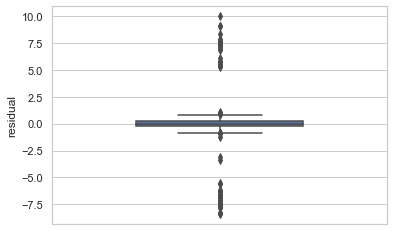

In [133]:
sns.boxplot(y = 'residual', data = outliers_data_df, width = 0.50)

Clearly, we can see that there are many outliers.

In [134]:
# find lower and upper bounds of standard boxplot
Q1, Q3 = np.percentile(outliers_data_df['residual'], [25, 75])
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR) 
upper_bound = Q3 + (1.5 * IQR) 

print("Q1              :", round(Q1, 3), 
      "\nQ3              :", round(Q3, 3), 
      "\nIQR             :", round(IQR, 3), 
      "\nLower Bound     :", round(lower_bound, 3), 
      "\nUpper Bound     :", round(upper_bound, 3))

Q1              : -0.214 
Q3              : 0.209 
IQR             : 0.422 
Lower Bound     : -0.847 
Upper Bound     : 0.842


Therefore, any residual values greater than 0.842 or lesser than -0.847 has to be identified as outliers. Let us apply this to the dataset and flag any outliers.

In [135]:
def flag_outliers(row):
    index = outliers_data_df[outliers_data_df['order_id'] == row.order_id].index.values.astype(int)[0]  # find index
    
    # if residual outside of the bounds, flag as outlier
    if ((row.residual > upper_bound) or (row.residual < lower_bound)):
        outliers_data_df.at[index, 'outlier_flag'] = True

    return None

outliers_data_df['outlier_flag'] = False
outliers_data_df.apply(flag_outliers, axis = 1);

Now that we have the outliers flagged, let us take a count and see how many are present.

In [136]:
len(outliers_data_df[(outliers_data_df.outlier_flag & outliers_data_df.original)])

54

In [137]:
len(outliers_data_df[outliers_data_df.outlier_flag])

62

There are 54 outliers in the outliers dataset and 8 more in the dirty data and missing data. Those 8 do not concern us anyway. <br>
Now, let us delete all the data not originally from the outliers dataset and all the observations which show outliers with respect to delivery fee.

In [138]:
outliers_data_df = outliers_data_df.drop(outliers_data_df[outliers_data_df.original == False].index)   # drop rows from other tables
outliers_data_df = outliers_data_df.drop(outliers_data_df[outliers_data_df.outlier_flag].index)        # drop outliers
len(outliers_data_df)

446

We now have 446 rows in the file - which looks right (500 - 54). Let us now think about exporting the file.
## 4.3 Exporting the File
Before exporting the file, we have a couple more things to do.
* Change the name of the loyalty column back to what it was.
* Remove all the extra columns added for analysis.

In [139]:
outliers_data_df.drop(outliers_data_df.columns[12:], axis = 1, inplace = True)            # drop extra columns
outliers_data_df = outliers_data_df.rename(columns={"loyalty":"customerHasloyalty?"})     # rename column 

# rounding off these values as they are in the input file
outliers_data_df['customer_lat'] = round(outliers_data_df['customer_lat'], 7)
outliers_data_df['customer_lon'] = round(outliers_data_df['customer_lon'], 7)
outliers_data_df['delivery_fee'] = round(outliers_data_df['delivery_fee'], 7)
outliers_data_df['distance_to_customer_KM'] = round(outliers_data_df['distance_to_customer_KM'], 3)

outliers_data_df.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
1,ORDZ06960,2018-06-15,13:24:30,Lunch,NS,"[('Steak', 9), ('Chicken', 10)]",725.00,-37.818733,145.015963,0,11.866,17.386153
2,ORDK09812,2018-01-28,08:50:42,Breakfast,BK,"[('Eggs', 8), ('Pancake', 9), ('Cereal', 10), ...",679.25,-37.811478,144.938166,0,10.034,17.598874
3,ORDJ11099,2018-11-11,18:28:43,Dinner,TP,"[('Salmon', 5), ('Fish&Chips', 1), ('Shrimp', ...",567.00,-37.818288,144.946777,0,9.283,15.149030
4,ORDA10794,2018-08-06,15:05:54,Lunch,BK,"[('Chicken', 10), ('Steak', 8), ('Burger', 7),...",1000.20,-37.811975,144.965722,0,7.447,13.247658
5,ORDA06808,2018-09-25,16:47:19,Dinner,BK,"[('Shrimp', 10), ('Salmon', 1), ('Fish&Chips',...",721.00,-37.817134,144.988808,0,5.776,12.661482


Everything looks good now. Onto exporting the file.

In [140]:
outliers_data_df.to_csv('Group149_outlier_data_solution.csv', index = False)  

# 5. Summary
In summary, this assessment task went through a few techniques for cleaning data. There were three separate tasks assigned:
* Cleaning Dirty Data
    * Correction of Time and Date Format Errors 
    * Correction of Time and Meal Type Mismatches
    * Correction of Meal Type and Meal Items Mismatches
    * Correction of Meal Item and Order Price Mismatches
    * Correction of Latitude and Longitude Issues
    * Correction of Branch Codes
    * Correction of Branch Code and Distance Mismatches
    * Correction of Loyalty Status and Delivery Fee Mismatches
* Imputing Missing Data
    * Imputing Missing Branch Codes
    * Imputing Missing Distances
    * Imputing Missing Delivery Fees
* Deleting Outliers
    * Deleting Outliers with respect to Delivery Fees

To help with these tasks, exploratory data analysis was done extensively on each of the three files. Visual techniques as well as non-visual techniques were used. Various methods were used for achieving the primary goals - including Djikstra's Algorithm, Linear Regression, Linear Algebra, Standard Boxplot Outlier Detection etc. Regular Expressions were also used at certain points. <br><br>
In all, 300 errors were detected and corrected in the dirty data file, 200 different missing values were imputed in the missing data file and 54 outlier rows were deleted from the outliers data file. <br><br>
The assessment gives us a good understanding of various data cleansing techniques that are used.

# 6. References

- Batchelder N. (2011). *How to use a variable inside a regular expression?* [Response to]. Retrieved from https://stackoverflow.com/questions/6930982/how-to-use-a-variable-inside-a-regular-expression<br>
- Dharmkar R. (2018). *What is the difference between re.match(), re.search() and re.findall() methods in Python?*. Retrieved from https://www.tutorialspoint.com/What-is-the-difference-between-re-match-re-search-and-re-findall-methods-in-Python<br>
- Ladd J., Otis J., Warren C. N., and Weingart S. (2018). *Exploring and Analyzing Network Data with Python*. Retrieved from https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python<br>
- matplotlib (2019). *matplotlib.pyplot.hist*. Retrieved from https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html<br>
- Pryke B. (2017). *SettingwithCopyWarning: How to Fix This Warning in Pandas*. Retrieved from https://www.dataquest.io/blog/settingwithcopywarning/<br>
- Syme K. (2017). *Number of edges differ when converting pandas dataframe to Networkx object* [Response to]. Retrieved from https://stackoverflow.com/questions/46309321/number-of-edges-differ-when-converting-pandas-dataframe-to-networkx-object<br>
- Waskom M. (2018). *seaborn.regplot*. Retrieved from https://seaborn.pydata.org/generated/seaborn.regplot.html<br>
- Waskom M. (2018). *seaborn.boxplot*. Retrieved from https://seaborn.pydata.org/generated/seaborn.boxplot.html<br>